In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp

import skimage.io

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from skimage.transform import resize


# <center> Exploring PCA: Mathematical Concepts, Algorithm, Implementation and Applications of Principal Component Analysis 

<center> <i> D. Tuleva </i>

<center> <i> Final Project for Math Concepts for Developers March 2023, SoftUni </i>
 


###  Abstract

Principal component analysis (PCA) is a technique for analyzing high-dimensional datasets and a useful tool for dimensionality reduction with minimal loss of information. PCA is a linear transformation of the data onto a new basis defined by chosen number of new, uncorrelated features, called principal components. The concept from linear algebra of Eigendecomposition, or the more generalized idea of Singular Value Decomposition is utilized to find the pairs of Eigenvectors and Eigenvalues, which represent the directions that capture the most variance and the associated amount of information that they describe. Deciding which Eigenvectors to keep as principal components is the real task when applying PCA. Projecting the data in lower-dimensional space has many applications - visual representation and finding patterns in data, compression and speeding up further processing. And of course  we cannot fail to mention Eigenface - applying PCA for facial recognition.

In this article, we provide a comprehensive, step-by-step exploration of the PCA algorithm and implement it using the NumPy library in Python. We apply our PCA and the implementation provided by scikit-learn to several small datasets and compare the results. The scikit-learn's more stable implementation is used on several bigger datasets to demonstrate PCA's performance at extreme dimensionality reduction, image compression and Eigenface-like algorithm called Eigenpet. The article is aimed to help achieve a better understanding of the underlying concepts and mathematical principals of PCA, it's applications and limitations. 

## Table of contents
1. [Introduction](#introduction)

2. [PCA Algorithm](#pca-algorithm)
    - [Step 1: Standardize the dataset](#step-1-standardize-the-dataset)
    - [Step 2: Calculate feature covariance](#step-2-calculate-feature-covariance-matrix)
    - [Step 3: Calculate principal components](#step-3-calculate-principal-components)
    - [Step 4: Create a feature vector and decide which principal components to keep](#step-4-create-a-feature-vector-and-decide-which-principal-components-to-keep)
    - [Step 5: Recast the data along the principal components axes](#step-5-recast-the-data-along-the-principal-components-axes)


3. [PCA Implementation](#pca-implementation-with-numpy)
    - [Our implementation](#our-implementation)
    - [Compare with sklearn on our mock dataset](#compare-with-sklearn-on-our-mock-dataset)
    - [Compare with sklearn on Iris dataset](#compare-with-sklearn-on-iris-dataset)
   

4. [PCA Advantages and Limitations](#pca-advantages-and-limitations)
    - [Non-linear correlations](#non-linear-correlations)
    - [Weak correlations](#weak-relationship-between-features)
    - [Kernel and Sparse PCA](#kernel-and-sparce-pca)

5. [PCA Applications](#pca-aplications)
    - [Dimensionality Reduction - Recipes](#dimentionality-reduction---recepies)
    - [Image Compression - Rose Image](#image-compression---rose-image)
    - [Eigenpets](#eigenpets)

## Introduction

[web uni](http://web.uni-plovdiv.bg/marta/tema-17.pdf)

The beginning of the theory of eigenvalues and eigenvectors dates back to the study of the rotation of a rigid body in the 18th century by Leonard Euler, followed by Joseph Louis Lagrange, who proved that the principal axes of the body are the eigenvectors of the inertia matrix. Jean d'Alembert discovered the connection between eigenvalues, eigenvectors, and matrices by solving a system of linear differential equations.

Eigenvalues and eigenvectors play a fundamental role in various fields of mathematics and physics, providing insights into the behavior of linear transformations and the properties of matrices. This concept is used by Principal Component Analysis to describe data trough their own underlying structure, projecting the data in their Eigenbasis ("eigen" meaning "own" or "characteristic" in German), which is the base formed by its principal components - the eigenvectors associated with the highest eigenvalues.

## PCA algorithm

[steps1](https://medium.com/analytics-vidhya/understanding-principle-component-analysis-pca-step-by-step-e7a4bb4031d9)

[steps2](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)

[steps3](https://medium.com/codex/principal-component-analysis-pca-how-it-works-mathematically-d5de4c7138e6)

In the following section we describe the Principal component analysis algorithm step by step. In order to be able to visualise how the method works, all mathematical operations are applied to small mock dataset with shape (?, 3) representing 3 features / variables (columns) and ? entries (rows).

In [3]:
mock_dataset = np.array([
    [1, 6, 1],
    [2, 5, 1], 
    [3, 8, 5], 
    [4, 3, 2], 
    [5, 1, 9],
    [6, 9, 2], 
    [7, 1, 7]
])
mock_dataset.shape

(7, 3)

In [4]:
mock_dataset.shape

(7, 3)

This is what our dataset looks like in 3D - each entry is represented by a dot with coordinates equal tho the value of each feature.

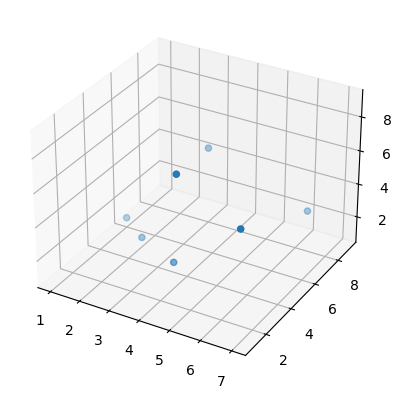

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(mock_dataset[:,0], mock_dataset[:,1], mock_dataset[:,2])
plt.show()

### Step 1: Standardize the dataset

In this step we scale the initial variables. Since PCA maximizes variance, features with larger range will affect output more than features with small ranges, which would lead to biased results. Therefore standartisation is the preferred scaling mathod - scaled variables have the same variance.

Mathematically standartization means calculating the mean $\mu$ and standard deviation $\sigma$ of each column (i.e. of each variable/feature in the dataset), then for each value $x_{i}$ subtracting the coresponding $ \mu $ and dividing by the coresponding $ \sigma $, where $n$ is number of rows and $i$ is the index of the row. As a result of the standartization we have scaled features, where each feature's mean is equal to zero and standart deviation is one.

$$\mu = \frac{1}{n} \sum_{i=0}^{n-1} x_{i}$$

$$ \sigma = \sqrt{\frac{1}{n} \sum_{i=0}^{n-1} (x_{i} - \mu)^2}$$

$$ x_{i\text{ new}} = \frac{x_{i} - \mu}{\sigma} $$




#### Standardize with numpy

In [6]:
n = mock_dataset.shape[0]
n # number of rows

7

In [7]:
m = mock_dataset.shape[1]
m # number of columns

3

Calculate mean $\mu$ of each column

In [8]:
mean_vec_calc = np.array([sum(mock_dataset[:,j])/n for j in range(m)])
mean_vec_calc # calculated with the formula above

array([4.        , 4.71428571, 3.85714286])

In [9]:
mean_vec_np = np.mean(mock_dataset, axis = 0)  # Vector with mean value of each column
mean_vec_np # calculated with numpy mean

array([4.        , 4.71428571, 3.85714286])

In [10]:
np.testing.assert_array_equal(mean_vec_calc, mean_vec_np)

Since no weighted averages are taken into account, the sample mean is the same as the expected value. This is why we calculate standart deviation with $n$ and not $n- 1$ (```ddof = 0```)

Calculate standart deviation $\sigma$ of each column

In [11]:
std_vec_calc = [np.sqrt(sum([(mock_dataset[i][j] - mean_vec_calc[j])**2 for i in range(n)]) / n) for j in range(m)]
std_vec_calc = np.array(std_vec_calc)
std_vec_calc # calculated with the formula above

array([2.        , 2.96234876, 2.94853821])

In [12]:
std_vec_np = np.std(mock_dataset, axis = 0, ddof = 0)  # Vector with the standart deviation of each column
std_vec_np

array([2.        , 2.96234876, 2.94853821])

In [13]:
np.testing.assert_array_equal(std_vec_calc, std_vec_np)

Scale the dataset

In [14]:
mock_dataset_stdr_np = (mock_dataset - mean_vec_np) / std_vec_np # Scale dataset
mock_dataset_stdr_np

array([[-1.5       ,  0.43401854, -0.96900317],
       [-1.        ,  0.09644856, -0.96900317],
       [-0.5       ,  1.10915849,  0.38760127],
       [ 0.        , -0.57869139, -0.62985206],
       [ 0.5       , -1.25383134,  1.7442057 ],
       [ 1.        ,  1.44672847, -0.62985206],
       [ 1.5       , -1.25383134,  1.06590348]])

Check standartized dataset's shape and assert $ \mu = 0 $ and $ \sigma = 1 $ for each column.

In [15]:
mock_dataset_stdr_np.shape

(7, 3)

In [16]:
np.mean(mock_dataset_stdr_np, axis = 0)

array([ 0.00000000e+00, -9.51619735e-17,  0.00000000e+00])

In [17]:
np.std(mock_dataset_stdr_np, axis = 0, ddof = 0)

array([1., 1., 1.])

#### Standardize with sklearn

In [18]:
scaler = StandardScaler() # Initilalize scaler

In [19]:
scaler.fit(mock_dataset) # Calculate parameters
print(f" scaler.mean_ = {scaler.mean_}")
print(f" scaler.scale_ = {scaler.scale_}")

 scaler.mean_ = [4.         4.71428571 3.85714286]
 scaler.scale_ = [2.         2.96234876 2.94853821]


In [20]:
mock_dataset_stdr_sklearn = scaler.transform(mock_dataset) # Scale dataset
mock_dataset_stdr_sklearn

array([[-1.5       ,  0.43401854, -0.96900317],
       [-1.        ,  0.09644856, -0.96900317],
       [-0.5       ,  1.10915849,  0.38760127],
       [ 0.        , -0.57869139, -0.62985206],
       [ 0.5       , -1.25383134,  1.7442057 ],
       [ 1.        ,  1.44672847, -0.62985206],
       [ 1.5       , -1.25383134,  1.06590348]])

In [21]:
mock_dataset_stdr_sklearn.shape # Check shape

(7, 3)

#### Compare standardization results

Assert the results of standartizing with numpy and sklearn are equal. 

In [22]:
np.testing.assert_array_equal(mean_vec_np, scaler.mean_) # Compare mean 

In [23]:
np.testing.assert_array_equal(std_vec_np, scaler.scale_) # Compare standart deviation

In [24]:
np.testing.assert_array_equal(mock_dataset_stdr_np, mock_dataset_stdr_sklearn)

### Step 2: Calculate feature covariance matrix

In this step corelations between the features are quantified by computing their covariance matrix. The covariance matrix is a p × p symmetric matrix (where p is the number of variables i.e. feature columns) that contains the covariance of all possible pairs of 2 features (including covariance with itself, which is equal to the feature variance).

|  | $f_{1}$ | $f_{2}$ | $f_{3}$ |
|:---:|:---:|:---:|:---:|
| $f_{1}$ | $cov(f_{1}, f_{1})$ | $cov(f_{1}, f_{2})$ | $cov(f_{1}, f_{3})$ |
| $f_{2}$ | $cov(f_{2}, f_{1})$ | $cov(f_{2}, f_{2})$ | $cov(f_{2}, f_{3})$ |
| $f_{3}$ | $cov(f_{3}, f_{1})$ | $cov(f_{3}, f_{2})$ | $cov(f_{3}, f_{3})$ |


Since  $cov(f_{j}, f_{j}) = var(f_{j})$, we have the variance of each initial feature in the main diagonal of the matrix. Since $cov(f_{j}, f_{k}) = cov(f_{k}, f_{j})$ the matrix is symmetrical with respect to the main diagonal, which means that the upper and the lower triangular portions of it have the same entries with mirrored possitions.

$$ A =     \left ( \begin{array}{ccc}
    var(f_{1}) & cov(f_{1}, f_{2}) & cov(f_{1}, f_{3}) \\
    cov(f_{1}, f_{2}) & var(f_{2}) & cov(f_{2}, f_{3}) \\
    cov(f_{1}, f_{3}) & cov(f_{2}, f_{3}) & var(f_{3}) \\
    \end{array} \right ) $$

$$ var(f_{j}) = \frac{1}{n}\sum_{i=0}^{n-1} \left( (x_{j,i} - \mu_{j})^{2} \right) $$

$$ cov(f_{j}, f_{k}) = \frac{1}{n}\sum_{i=0}^{n-1} \left( (x_{j,i} - \mu_{j})(x_{k,i} - \mu_{k}) \right) $$

Since our dataset is standartized $\mu = 0$

$$ var(f_{j}) = \frac{1}{n}\sum_{i=0}^{n-1} \left( (x_{j,i})^{2} \right) $$

$$ cov(f_{j}, f_{k}) = \frac{1}{n}\sum_{i=0}^{n-1} \left( (x_{j,i} )(x_{k,i} ) \right) $$

In [25]:
# Variance f1
var_f1 = sum([mock_dataset_stdr_np[:,0][i] ** 2 for i in range(n)]) / n

In [26]:
# Variance f2
var_f2 = sum([mock_dataset_stdr_np[:,1][i] ** 2 for i in range(n)]) / n

In [27]:
# Variance f3
var_f3 = sum([mock_dataset_stdr_np[:,2][i] ** 2 for i in range(n)]) / n

In [28]:
# Covariance f1, f2
cov_f1_f2 = sum([(mock_dataset_stdr_np[:,0][i] * mock_dataset_stdr_np[:,1][i]) for i in range(n)]) / n

In [29]:
# Covariance f1, f3
cov_f1_f3 = sum([(mock_dataset_stdr_np[:,0][i] * mock_dataset_stdr_np[:,2][i]) for i in range(n)]) / n

In [30]:
# Covariance f2, f3
cov_f2_f3 = sum([(mock_dataset_stdr_np[:,1][i] * mock_dataset_stdr_np[:,2][i]) for i in range(n)]) / n

Covariance matrix calculated

In [31]:
cov_calc = np.dot(mock_dataset_stdr_np.T, mock_dataset_stdr_np) / n
cov_calc

array([[ 1.        , -0.33756998,  0.5814019 ],
       [-0.33756998,  1.        , -0.59346442],
       [ 0.5814019 , -0.59346442,  1.        ]])

In [32]:
# Assert the results calculated with matrix multiplication are equal to these calculated one by one with the formuals above
# abs(desired-actual) < float64(1.5 * 10**(-decimal))

np.testing.assert_almost_equal(cov_calc[0][0], var_f1)
np.testing.assert_almost_equal(cov_calc[1][1], var_f2)
np.testing.assert_almost_equal(cov_calc[2][2], var_f3)

np.testing.assert_almost_equal(cov_calc[0][1], cov_f1_f2) 
np.testing.assert_almost_equal(cov_calc[0][2], cov_f1_f3) 
np.testing.assert_almost_equal(cov_calc[1][2], cov_f2_f3)

np.testing.assert_almost_equal(cov_calc[1][0], cov_f1_f2) 
np.testing.assert_almost_equal(cov_calc[2][0], cov_f1_f3) 
np.testing.assert_almost_equal(cov_calc[2][1], cov_f2_f3)

We compute the covariance matrix with numpy. Since we need the covariance column-wise, we set ```rowvar = False```. ```ddof=0``` means that no bias term is considered in the calculations.  

In [33]:
cov_np = np.cov(mock_dataset_stdr_np, rowvar = False, ddof=0)
cov_np

array([[ 1.        , -0.33756998,  0.5814019 ],
       [-0.33756998,  1.        , -0.59346442],
       [ 0.5814019 , -0.59346442,  1.        ]])

In [34]:
np.testing.assert_array_almost_equal(cov_calc, cov_np, decimal = 10) # abs(desired-actual) < 1.5 * 10**(-decimal)

### Step 3: Calculate principal components

Principal components are new set of variables, that are linear combinations of the initial variables, constructed in such a way that the new vaeiables are uncorelated and variance of each one is maximized. Most of the information is compressed into the first component, and every ohter has less and less input in describing the dataset. The number of principal components is equal to the number of initial variables, but by discarding the components with low information and considering the remaining components as the new variables we can reduce dimensionality with minimal loss of information. However this leads to less interpretability since the new variables have no real meaning.
Geometrically speaking, principal components represent the directions of the data that explain a maximal amount of variance. Simplified explanation could be that principal components are new axes that provide the best angle to observe and visualise the data.

#### Eigendecpmposition - eigenvalues and eigenvectors

Eigendecomposition is the decomposition (factorization) of a matrix into a set of eigenvalues and eigenvectors. 
$$ \boldsymbol A = \boldsymbol Q \boldsymbol \Lambda \boldsymbol Q^{-1} $$
where Q is the martix whose $i^{\text th} $ is the is the eigenvector $v_i$ of $\boldsymbol A$ and $\boldsymbol \Lambda$ is diagonal matrix whose nonzero elements are the corresponding eigenvalues $\boldsymbol \Lambda_{ii} = \lambda_i$.
Only diagonalizable matrices can be factorized in this way. Geometrically speaking, the eigenvectors of $\boldsymbol A$ are the vectors that $\boldsymbol A$ elongates or shrinks, and the amount that they elongate/shrink by is the eigenvalue. 
Since eigenvectors are orthogonal to each other, $ \boldsymbol Q $ is also a unitary matrix, meaning that
$$ \boldsymbol A = \boldsymbol Q \boldsymbol \Lambda \boldsymbol Q^{-1} = \boldsymbol Q \boldsymbol \Lambda \boldsymbol Q^T $$

https://notes.andrewgurung.com/data-science/linear-algebra/eigenvalues-and-eigenvectors

![eigenpic](https://2846029938-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-LZeF1eMsLQZIJY8oZvh%2F-Lc1UZ0TsFOfaxvZ-Rzr%2F-Lc1VnOSGZJQp0wDxliI%2FEigenDecomposition.png?alt=media&token=07965758-ddad-4095-8d85-a9b60e81bc7e)

$A$ is square matrix ($m$ by $m$) and $v$ is nonzero $m$-vector, where all values belong to the real numbers set. In our case $A$ is the feature covariance matrix which is both square and symetrical, which means that it is diagonalizable, and $v$ is $m$-dimentional vector, where $m$ is the number of features.
$$ A \in \mathcal{M}_{m \times m}  \left( \mathbb{R} \right)$$
The product $Av$ is also m-vector. For a given matrix $A$ we try to find a vector $v$ for which the product $Av$ is a scalar $\lambda$ multiple of $v$: 
$$ Av = \lambda v $$
In this case $v$ is column vector and is called left eigenvector of $A$. If $v$ is row vector the product would be 
$$ vA = \lambda  v$$
and v is called right eigenvector of $A$. Scince matrix multiplication is not comutative right and left eigenvectors are not nesseserily equal. In the following example only right eigenvectors are evaluated.

$$ Av = \lambda v $$
$$ \Rightarrow Av - \lambda v = 0 $$
$$ \Rightarrow Av - \lambda I v = 0 $$
$$ \Rightarrow \left( A - \lambda I \right) v = 0 $$

$I$ is an Identity matrix with dimention equal to that of A.

$A - \lambda I $ is $ m \times m $, therefore if its determinant is nonzero, the last equation will have exactly one solution $ v = 0 $. $ v $ is nonzero vector by definition, therefore there are solutions only when the determinant of $A - \lambda I $ equals zero.

$$ \lvert A - \lambda I \rvert = 0 $$

[eigen bg](http://web.uni-plovdiv.bg/marta/tema-17.pdf)

[wiki eigen](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors)

This equation is polynomial of degree $ m $ (equal to the number of rows/columns) and is called characteristic equation of the matrix $A$ and the polynomial 
$$p(\lambda) = \lvert A - \lambda I \rvert $$ 
is it's characteristic polynomial. The polynomial could be factored in the form
$$ p(\lambda) = \left ( \lambda_1 - \lambda \right ) \left ( \lambda_2 - \lambda \right ) \dots \left ( \lambda_m - \lambda \right )$$
but it is important to note that even when the coeffitients are real numbers the roots can be complex.

The roots of this equation are called characteristic value, characteristic root or __eigenvalues__. The set of all eigenvalues is called spectrum of $A$. If $A$ is symmetric ( $A = A^T$), then $A$ is orthogonally diagonalizable and has only real eigenvalues and and orthogonal, non-zero real eigenvectors. This is often reffered to as the Spectral Theorem.

##### Eigendecomposition with sympy

We solve the characteristic equation of the matrix of covariance of our mock dataset

$$ A - \lambda I = \left ( \begin{array}{ccc}
    var(f_{1}) & cov(f_{1}, f_{2}) & cov(f_{1}, f_{3}) \\
    cov(f_{1}, f_{2}) & var(f_{2}) & cov(f_{2}, f_{3}) \\
    cov(f_{1}, f_{3}) & cov(f_{2}, f_{3}) & var(f_{3}) \\
    \end{array} \right ) - \lambda \left ( \begin{array}{ccc}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 1 \\
    \end{array} \right ) = $$

$$ = \left ( \begin{array}{ccc}
    var(f_{1}) & cov(f_{1}, f_{2}) & cov(f_{1}, f_{3}) \\
    cov(f_{1}, f_{2}) & var(f_{2}) & cov(f_{2}, f_{3}) \\
    cov(f_{1}, f_{3}) & cov(f_{2}, f_{3}) & var(f_{3}) \\
    \end{array} \right ) - \left ( \begin{array}{ccc}
    \lambda & 0 & 0 \\
    0 & \lambda & 0 \\
    0 & 0 & \lambda \\
    \end{array} \right ) = $$

$$ = \left ( \begin{array}{ccc}
    var(f_{1}) - \lambda & cov(f_{1}, f_{2}) & cov(f_{1}, f_{3}) \\
    cov(f_{1}, f_{2}) & var(f_{2}) - \lambda & cov(f_{2}, f_{3}) \\
    cov(f_{1}, f_{3}) & cov(f_{2}, f_{3}) & var(f_{3}) - \lambda \\
    \end{array} \right ) $$


In [35]:
lamda = sp.symbols("lambda")

In [36]:
A = sp.Matrix(cov_np)
A

Matrix([
[               1.0, -0.337569975519289,  0.581401899733811],
[-0.337569975519289,                1.0, -0.593464423395746],
[ 0.581401899733811, -0.593464423395746,                1.0]])

In [37]:
A_lambda = A - lamda * (sp.eye(3))
A_lambda

Matrix([
[      1.0 - lambda, -0.337569975519289,  0.581401899733811],
[-0.337569975519289,       1.0 - lambda, -0.593464423395746],
[ 0.581401899733811, -0.593464423395746,       1.0 - lambda]])

In [38]:
char_polynomial = A_lambda.det()
char_polynomial

-lambda**3 + 3.0*lambda**2 - 2.19581832077738*lambda + 0.428769516322743

In [39]:
lambda_set = sp.solveset(char_polynomial,lamda)
lambda_set

{0.320928636511124, 0.662536241796633, 2.01653512169224}

We sort eigenvalues in descending order

In [40]:
eigenvalues = sorted(list(lambda_set), reverse=True)

We unpack eigenvalues for further calculations:

In [41]:
lambda_1, lambda_2, lambda_3 = eigenvalues

In [42]:
l1, l2, l3 = sp.symbols("lambda1, lambda2, lambda3")

Eigenvalues are:

In [43]:
eigenvalues 

[2.01653512169224, 0.662536241796633, 0.320928636511124]

In [44]:
sp.Eq(l1,lambda_1)

Eq(lambda1, 2.01653512169224)

In [45]:
sp.Eq(l2,lambda_2)

Eq(lambda2, 0.662536241796633)

In [46]:
sp.Eq(l3,lambda_3)

Eq(lambda3, 0.320928636511124)

$$ \boldsymbol \Lambda = $$

In [47]:
L = sp.Matrix([[lambda_1, 0, 0],[0, lambda_2, 0], [0,0,lambda_3]]) 
L

Matrix([
[2.01653512169224,                 0,                 0],
[               0, 0.662536241796633,                 0],
[               0,                 0, 0.320928636511124]])

To find $v $ we substitute with each $\lambda$ in $ Av = \lambda v $ and search for nonzero soutions for $v$. Since $ \lvert A - \lambda I \rvert = 0 $ the system is indetermined, which means there is no unique solution, but a set of solutions for each $\lambda$. Theese vectors that are solutions are called eigenvectors. For convinience we take the unit vector from each set. Resulting vectors are linearly independant since: det v v v != 0.

In [48]:
v1, v2, v3 = sp.symbols("v1, v2, v3")

In [49]:
v = sp.Matrix([[v1],[v2],[v3]])
v

Matrix([
[v1],
[v2],
[v3]])

$$\left( A - \lambda I \right) v = 0 $$

In [50]:
sp.MatMul(A_lambda, v) 

Matrix([
[      1.0 - lambda, -0.337569975519289,  0.581401899733811],
[-0.337569975519289,       1.0 - lambda, -0.593464423395746],
[ 0.581401899733811, -0.593464423395746,       1.0 - lambda]])*Matrix([
[v1],
[v2],
[v3]])

Substitute with $\lambda_1$

In [51]:
lambda_1

2.01653512169224

In [52]:
A_lambda_1 = A_lambda.subs(lamda, lambda_1)
sp.MatMul(A_lambda_1, v)

Matrix([
[ -1.01653512169224, -0.337569975519289,  0.581401899733811],
[-0.337569975519289,  -1.01653512169224, -0.593464423395746],
[ 0.581401899733811, -0.593464423395746,  -1.01653512169224]])*Matrix([
[v1],
[v2],
[v3]])

In [53]:
syst_1 = A_lambda_1 * v
syst_1

Matrix([
[-1.01653512169224*v1 - 0.337569975519289*v2 + 0.581401899733811*v3],
[-0.337569975519289*v1 - 1.01653512169224*v2 - 0.593464423395746*v3],
[ 0.581401899733811*v1 - 0.593464423395746*v2 - 1.01653512169224*v3]])

In [54]:
syst_1[0]

-1.01653512169224*v1 - 0.337569975519289*v2 + 0.581401899733811*v3

In [55]:
v1_ = sp.solve(syst_1[0], v1)[0]
v1_

-0.332079008699012*v2 + 0.571944724119264*v3

In [56]:
syst_1[1]

-0.337569975519289*v1 - 1.01653512169224*v2 - 0.593464423395746*v3

In [57]:
v2_v3_ = syst_1[1].subs(v1, v1_)
v2_v3_ 

-0.904435218855248*v2 - 0.786535789915072*v3

In [58]:
v2_end = sp.solve(v2_v3_, v2)[0]
v2_end

-0.869643036358754*v3

In [59]:
v1_end = v1_.subs(v2, v2_end)
v1_end

0.860734921555279*v3

We have expressed the solution for the eigenvectors assotiated with $\lambda_1$ with only one parameter ($v_3$):

In [60]:
v_lambda_1 = v.subs([(v1, v1_end), (v2, v2_end)])
v_lambda_1

Matrix([
[ 0.860734921555279*v3],
[-0.869643036358754*v3],
[                   v3]])

Since the length of the vector is not important, and we know that v3 is not zero (v is nonzero by definition) we can divide by v3:

In [61]:
v_lambda_1 = v_lambda_1 / v3
v_lambda_1

Matrix([
[ 0.860734921555279],
[-0.869643036358754],
[                 1]])

We calculate the unit vector (the vector with lenght of 1) for our final result for the eigenvector belonging to the eigenvalue $\lambda_1$

$$ \hat{v} = \frac v {|v|} \text{     -    unit vector}$$
$$|v| = \sqrt{v_1^2 + v_2^2 + v_3^2} \text{   -   length}$$

In [62]:
v_length_ = sp.sqrt(v_lambda_1[0]**2 + v_lambda_1[1]**2 + v_lambda_1[2]**2)
v_length_

1.58023530395699

In [63]:
v_lambda_1_unit = v_lambda_1 / v_length_
v_lambda_1_unit

Matrix([
[ 0.544687819212717],
[-0.550325027026749],
[ 0.632817149127062]])

We calculate eigenvectors of $\lambda_2$ and $\lambda_3$ the same way:

In [64]:
lambda_2

0.662536241796633

In [65]:
A_lambda_2 = A_lambda.subs(lamda, lambda_2)
sp.MatMul(A_lambda_2, v)

Matrix([
[ 0.337463758203367, -0.337569975519289,  0.581401899733811],
[-0.337569975519289,  0.337463758203367, -0.593464423395746],
[ 0.581401899733811, -0.593464423395746,  0.337463758203367]])*Matrix([
[v1],
[v2],
[v3]])

In [66]:
syst_2 = A_lambda_2 * v

In [67]:
v1_ = sp.solve(syst_2[0], v1)[0] # variables with _ suffix are reused

In [68]:
v2_v3_ = syst_2[1].subs(v1, v1_)

In [69]:
v2_end_ = sp.solve(v2_v3_, v2)[0]

In [70]:
v1_end_ = v1_.subs(v2, v2_end_)

In [71]:
v_lambda_2 = v.subs([(v1, v1_end_), (v2, v2_end_)])

In [72]:
v_lambda_2 = v_lambda_2 / v3

In [73]:
v_length_ = sp.sqrt(v_lambda_2[0]**2 + v_lambda_2[1]**2 + v_lambda_2[2]**2)

In [74]:
v_lambda_2_unit = v_lambda_2 / v_length_
v_lambda_2_unit

Matrix([
[-0.717803741536588],
[-0.696134163214217],
[0.0124505197529029]])

In [75]:
lambda_3

0.320928636511124

In [76]:
A_lambda_3 = A_lambda.subs(lamda, lambda_3)
sp.MatMul(A_lambda_3, v)

Matrix([
[ 0.679071363488876, -0.337569975519289,  0.581401899733811],
[-0.337569975519289,  0.679071363488876, -0.593464423395746],
[ 0.581401899733811, -0.593464423395746,  0.679071363488876]])*Matrix([
[v1],
[v2],
[v3]])

In [77]:
syst_3 = A_lambda_3 * v

In [78]:
v1_ = sp.solve(syst_3[0], v1)[0]

In [79]:
v2_v3_ = syst_3[1].subs(v1, v1_)

In [80]:
v2_end_ = sp.solve(v2_v3_, v2)[0]

In [81]:
v1_end_ = v1_.subs(v2, v2_end_)

In [82]:
v_lambda_3 = v.subs([(v1, v1_end_), (v2, v2_end_)])

In [83]:
v_lambda_3 = v_lambda_3 / v3

In [84]:
v_length_ = sp.sqrt(v_lambda_3[0]**2 + v_lambda_3[1]**2 + v_lambda_3[2]**2)

In [85]:
v_lambda_3_unit = v_lambda_3 / v_length_
v_lambda_3_unit

Matrix([
[-0.433673803955668],
[  0.46102016380419],
[ 0.774201162701645]])

Our eigenvector matrix $\boldsymbol Q$:

In [86]:
Q = sp.Matrix.hstack(v_lambda_1_unit, v_lambda_2_unit, v_lambda_3_unit)
Q

Matrix([
[ 0.544687819212717, -0.717803741536588, -0.433673803955668],
[-0.550325027026749, -0.696134163214217,   0.46102016380419],
[ 0.632817149127062, 0.0124505197529029,  0.774201162701645]])

Finnaly the eigendecomposition of $\boldsymbol A$:
$$ \boldsymbol A = \boldsymbol Q \boldsymbol \Lambda \boldsymbol Q^T $$

In [87]:
sp.MatMul(Q,L,Q.T)

Matrix([
[ 0.544687819212717, -0.717803741536588, -0.433673803955668],
[-0.550325027026749, -0.696134163214217,   0.46102016380419],
[ 0.632817149127062, 0.0124505197529029,  0.774201162701645]])*Matrix([
[2.01653512169224,                 0,                 0],
[               0, 0.662536241796633,                 0],
[               0,                 0, 0.320928636511124]])*Matrix([
[ 0.544687819212717, -0.550325027026749,  0.632817149127062],
[-0.717803741536588, -0.696134163214217, 0.0124505197529029],
[-0.433673803955668,   0.46102016380419,  0.774201162701645]])

##### Eigendecomposition with numpy

Numpy has a function to directly calculate eigenvectors and eigenvalues:

In [88]:
eig_values, eig_vectors = np.linalg.eig(cov_np)

In [89]:
eig_values

array([2.01653512, 0.66253624, 0.32092864])

In [90]:
eig_vectors

array([[-0.54468782,  0.71780374, -0.4336738 ],
       [ 0.55032503,  0.69613416,  0.46102016],
       [-0.63281715, -0.01245052,  0.77420116]])

Sort eigenvalues from lagest to smallest and rearrange the eigenvectors, so that we have eigenvalue and corresponding eigenvector on the same index in both arrays.

In [91]:
idx = eig_values.argsort()[::-1]   
eig_values = eig_values[idx]
eig_vectors = eig_vectors[:,idx]

In [92]:
eig_values

array([2.01653512, 0.66253624, 0.32092864])

In [93]:
eig_vectors

array([[-0.54468782,  0.71780374, -0.4336738 ],
       [ 0.55032503,  0.69613416,  0.46102016],
       [-0.63281715, -0.01245052,  0.77420116]])

##### Compare simpy and numpy eigenvectors and eigenvalues

In order to compare results from we cast sympy results to numpy arrays.

In [94]:
type(eigenvalues), type(Q)

(list, sympy.matrices.dense.MutableDenseMatrix)

In [95]:
eig_values_sp = np.array(eigenvalues)
eig_values_sp

array([2.01653512169224, 0.662536241796633, 0.320928636511124],
      dtype=object)

In [96]:
np.testing.assert_array_almost_equal(eig_values, eig_values_sp) # Eigenvalues are equal

In [97]:
eig_vectors_sp = np.array(Q)
eig_vectors_sp

array([[0.544687819212717, -0.717803741536588, -0.433673803955668],
       [-0.550325027026749, -0.696134163214217, 0.461020163804190],
       [0.632817149127062, 0.0124505197529029, 0.774201162701645]],
      dtype=object)

In [98]:
eig_vectors

array([[-0.54468782,  0.71780374, -0.4336738 ],
       [ 0.55032503,  0.69613416,  0.46102016],
       [-0.63281715, -0.01245052,  0.77420116]])

Not all eigenvectors are equal, some have opposite direction:

In [99]:
np.testing.assert_array_almost_equal(eig_vectors[:,0],  -1 * eig_vectors_sp[:,0])
np.testing.assert_array_almost_equal(eig_vectors[:,1],  -1 * eig_vectors_sp[:,1])
np.testing.assert_array_almost_equal(eig_vectors[:,2], eig_vectors_sp[:,2])

#### Singular value decomposition

Some of the implementations of PCA, including the sklearn implementation, use singular value decomposition (SVD) instead of 
eigendecomposition to compute the eigenvector/eigenvalue pairs. Advantage of SVD is that it is more numerically accurate and can be applied on any matrix regardless of its shape and does not require the computation of the feature correlation matrix. 

SVD is a matrix factorization method that generalizes the eigendecomposition. SVD decomposes a $ m \times n $ matrix $\boldsymbol M$ into three components: 

$$\boldsymbol U_{ m \times m} \text{   - left singular vectors in columns} $$ 
$$\boldsymbol \Sigma_{ m \times n } \text{   - diagonal of singular values}$$
$$\boldsymbol V_{ n \times n } \text{   - right singular vectors in columns}$$ 

$\boldsymbol U$ and $\boldsymbol V$ are both unitary matrices meaning that their transpose is also their inverse.

 


<img src="https://upload.wikimedia.org/wikipedia/commons/c/c8/Singular_value_decomposition_visualisation.svg" alt="SVG image" style="width: 600px;"/>

[By Cmglee - Own work, CC BY-SA 4.0,](https://commons.wikimedia.org/w/index.php?curid=67853297)

[svd](https://towardsdatascience.com/simple-svd-algorithms-13291ad2eef2#:~:text=General%20formula%20of%20SVD%20is,columns%20are%20left%20singular%20vectors)

We can think of SVD as breaking down the linear transformation performed by $\boldsymbol M $ into a rotation ($\boldsymbol U$), a scaling ($\boldsymbol \Sigma$), and another rotation ($\boldsymbol V$).

$$ \boldsymbol M = \boldsymbol U  \boldsymbol \Sigma \boldsymbol V^T $$

which can be transformed to the equivalent form:

$$ \boldsymbol M^T \boldsymbol M = (\boldsymbol U  \boldsymbol \Sigma \boldsymbol V^T)^T \boldsymbol U  \boldsymbol \Sigma \boldsymbol V^T = 
\boldsymbol V  \boldsymbol \Sigma^T \boldsymbol \Sigma \boldsymbol V^T =
\boldsymbol V  \hat{\boldsymbol \Sigma}^2 \boldsymbol V^T$$

where $\hat{\boldsymbol \Sigma}$ is square diagonal matrix with the singular values of $\boldsymbol M$ and the excess zeroes cropped, so that it satisfies the condition $\hat{\boldsymbol \Sigma}^2 = \boldsymbol \Sigma^T \boldsymbol \Sigma $.

##### Relationship between SVD and eigendecomposition





From eigendecomposition we have
$$ \boldsymbol A = \boldsymbol Q \boldsymbol \Lambda \boldsymbol Q^T $$
$$ \boldsymbol M^T \boldsymbol M = \boldsymbol Q \boldsymbol \Lambda \boldsymbol Q^T $$
we substitute $\boldsymbol M^T \boldsymbol M $ with its singular decomposition
$$\boldsymbol V  \hat{\boldsymbol \Sigma}^2 \boldsymbol V^T = \boldsymbol Q \boldsymbol \Lambda \boldsymbol Q^T$$

The singular values are the square roots of the eigenvalues.

##### Singular value decomposition with numpy

In [100]:
mock_dataset_stdr_sklearn.shape

(7, 3)

In [101]:
u_ds, sigma_ds, vh_ds = np.linalg.svd(mock_dataset_stdr_np)
u_cov, sigma_cov, vh_cov = np.linalg.svd(cov_np)

In [102]:
eig_values

array([2.01653512, 0.66253624, 0.32092864])

In [103]:
sigma_cov

array([2.01653512, 0.66253624, 0.32092864])

In [104]:
sigma_ds

array([3.75709274, 2.15354445, 1.49883303])

In [105]:
eig_vectors.T

array([[-0.54468782,  0.55032503, -0.63281715],
       [ 0.71780374,  0.69613416, -0.01245052],
       [-0.4336738 ,  0.46102016,  0.77420116]])

In [106]:
vh_cov

array([[-0.54468782,  0.55032503, -0.63281715],
       [-0.71780374, -0.69613416,  0.01245052],
       [-0.4336738 ,  0.46102016,  0.77420116]])

In [107]:
vh_ds

array([[ 0.54468782, -0.55032503,  0.63281715],
       [-0.71780374, -0.69613416,  0.01245052],
       [ 0.4336738 , -0.46102016, -0.77420116]])

In [108]:
np.dot(mock_dataset_stdr_np, vh_ds)

array([[-1.54880315,  0.97008241, -0.19361859],
       [-1.03415025,  0.92991388,  0.11858706],
       [-0.90040951, -0.6756526 , -0.60268033],
       [ 0.1422365 ,  0.69322134,  0.48042719],
       [ 1.92876506, -0.20644168, -1.04956836],
       [-0.76692962, -1.26706764,  1.13846187],
       [ 2.17929097, -0.44405571,  0.10839116]])

#### Step 4: Create a feature vector and decide which principal components to keep

In [109]:
def plot_explained_variance(*variance_ratios, label_list = [], ylim_upper = 1): 
    num_plots = len(variance_ratios)
    width = 0.8 / num_plots
    offset = - num_plots * width / 2 + width / 2
    
    num_eigenvalues = np.arange(1, len(variance_ratios[0]) + 1)
    
    for explained_variance_ratio in variance_ratios:
         
        plt.bar(offset + num_eigenvalues, explained_variance_ratio, width)
        offset += width
    
    plt.xlabel('Eigen Value')
    plt.ylabel('Variation explained')
    plt.xticks(num_eigenvalues)
    plt.ylim(0, ylim_upper)
    plt.legend(label_list)

    plt.show()

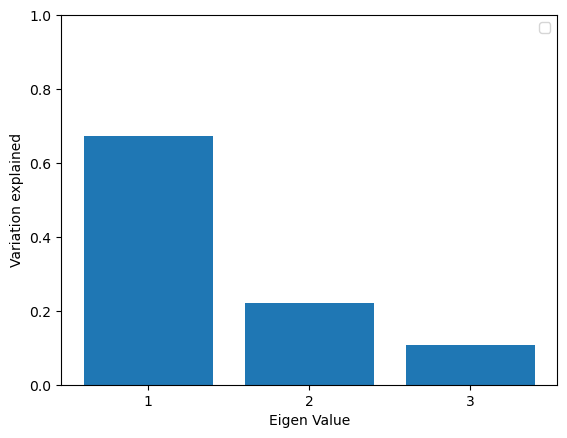

In [110]:
plot_explained_variance(eig_values / np.sum(eig_values))

In [111]:
num_components = 2 # number of principal components to keep

In [112]:
feature_vector = eig_vectors[:, :num_components]
feature_vector

array([[-0.54468782,  0.71780374],
       [ 0.55032503,  0.69613416],
       [-0.63281715, -0.01245052]])

#### Step 5: Recast the data along the principal components axes

To recast the data along the principal components axes we multiply the dataset by the feature vector.

In [113]:
mock_dataset_stdr_np.shape, feature_vector.shape

((7, 3), (3, 2))

In [114]:
mock_dataset_transformed = np.dot(mock_dataset_stdr_np, feature_vector)
mock_dataset_transformed

array([[ 1.66908481, -0.76250589],
       [ 1.2109677 , -0.63859801],
       [ 0.63746086,  0.40839541],
       [ 0.08011283, -0.39500486],
       [-2.06612195, -0.53564923],
       [ 0.65006425,  1.73276284],
       [-2.1815685 ,  0.19059973]])

In [115]:
mock_dataset_transformed_svd = np.dot(mock_dataset_stdr_np, vh_ds.T[:, :2])
mock_dataset_transformed_svd

array([[-1.66908481,  0.76250589],
       [-1.2109677 ,  0.63859801],
       [-0.63746086, -0.40839541],
       [-0.08011283,  0.39500486],
       [ 2.06612195,  0.53564923],
       [-0.65006425, -1.73276284],
       [ 2.1815685 , -0.19059973]])

In [116]:
np.testing.assert_array_almost_equal(mock_dataset_transformed,  -1 * mock_dataset_transformed_svd)

One projection is equal to the other rotated by $\pi$ ($180 \degree $), which means they carry the same information.

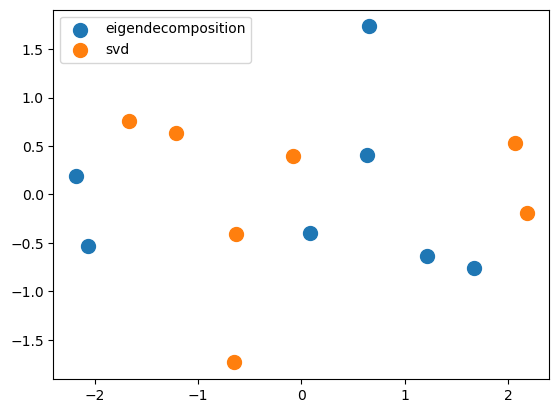

In [117]:
plt.scatter(mock_dataset_transformed[:,0], mock_dataset_transformed[:,1], 100, label = "eigendecomposition")
plt.scatter(mock_dataset_transformed_svd[:,0], mock_dataset_transformed_svd[:,1], 100, label = "svd")
plt.legend()
plt.show()

## PCA implementation with numpy

#### Our implementation

In [118]:
class PCA_np:
    def __init__(self, n_components = None):  # todo props for no setting 
        self.n_components = n_components # None = all
        self.cov_matrix = None              
        self.eigenvalues = None
        self.eigenvectors = None
        self.n_features_ = None
        self.n_samples_ = None
        self.components_ = None # self.eigenvectors[:,:n_components]
        self.explained_variance_ = None # self.eigenvalues[n_components]
        self.explained_variance_ratio_ = None   # self.eigenvalues[n_components] / sum(self.eigenvalues)
    
    def fit(self, matrix):
        assert self.cov_matrix is None, "Cannot fit data twice"
        assert type(matrix) == type(np.array([0])), "input np.array only"
        
        self.n_samples_, self.n_features_ = matrix.shape
        
        self.cov_matrix = np.cov(matrix, rowvar = False, ddof=1)  # Compute feature covariance matrix 
        
        eig_values, eig_vectors = np.linalg.eig(self.cov_matrix)  # Compute eigenvalues and eigenvectors
        
        idx = eig_values.argsort()[::-1]   # Sort eigenvalues in decreasing order and rearrange eigenvectors
        eig_values = eig_values[idx]       # to match their corresponding eigenvalue's index
        eig_vectors = eig_vectors[:,idx]
        
        self.eigenvalues = eig_values      # Set eigenvalues 
        self.eigenvectors = eig_vectors    # Set eigenvectors
        
        n = self.n_features_
        
        if self.n_components and self.n_components < self.n_features_:
            n = self.n_components
        
        self.components_ = eig_vectors[:,:n]
        self.explained_variance_ = eig_values[:n]
        self.explained_variance_ratio_ = (eig_values / np.sum(eig_values))[:n] # Set explained variance ratio
        
        
    def transform(self, matrix):
        assert self.cov_matrix is not None, "No fitted data"
        assert matrix.shape[1] == self.n_features_, "Number of features does not match"
        
        return np.dot(matrix, self.components_)
      
        

In [119]:
pca_try = PCA_np()

In [120]:
pca_try.fit(mock_dataset_stdr_np)

In [121]:
pca_try.eigenvalues

array([2.35262431, 0.77295895, 0.37441674])

In [122]:
pca_try.eigenvectors

array([[-0.54468782,  0.71780374, -0.4336738 ],
       [ 0.55032503,  0.69613416,  0.46102016],
       [-0.63281715, -0.01245052,  0.77420116]])

In [123]:
pca_try.transform(mock_dataset_stdr_np)

array([[ 1.66908481, -0.76250589,  0.10039863],
       [ 1.2109677 , -0.63859801, -0.27206484],
       [ 0.63746086,  0.40839541,  1.02826268],
       [ 0.08011283, -0.39500486, -0.75442059],
       [-2.06612195, -0.53564923,  0.55548765],
       [ 0.65006425,  1.73276284, -0.25433501],
       [-2.1815685 ,  0.19059973, -0.40332852]])

In [124]:
pca_try.n_components = 2
pca_try.n_components


2

In [125]:
pca_try.transform(mock_dataset_stdr_np)

array([[ 1.66908481, -0.76250589,  0.10039863],
       [ 1.2109677 , -0.63859801, -0.27206484],
       [ 0.63746086,  0.40839541,  1.02826268],
       [ 0.08011283, -0.39500486, -0.75442059],
       [-2.06612195, -0.53564923,  0.55548765],
       [ 0.65006425,  1.73276284, -0.25433501],
       [-2.1815685 ,  0.19059973, -0.40332852]])

##### Compare with sklearn on our mock dataset

We apply PCA on our standardized mock dataset once with sklearn and once with our implementation and compare the results. Both are initialised without specifying number of components, which means we keep all principal components at first.

In [126]:
pca_np = PCA_np()  # our implementation 
pca_sk = PCA()     # sklearn

In [127]:
pca_np.fit(mock_dataset_stdr_sklearn)
pca_sk.fit(mock_dataset_stdr_sklearn)

eig_values_np = pca_np.explained_variance_
eig_vectors_np = pca_np.components_

eig_values_sk = pca_sk.explained_variance_
eig_vectors_sk = pca_sk.components_

In [128]:
eig_values_np

array([2.35262431, 0.77295895, 0.37441674])

In [129]:
eig_values_sk

array([2.35262431, 0.77295895, 0.37441674])

In [130]:
np.testing.assert_array_almost_equal(eig_values_np, eig_values_sk)

In [131]:
pca_np.explained_variance_ratio_

array([0.67217837, 0.22084541, 0.10697621])

In [132]:
pca_sk.explained_variance_ratio_

array([0.67217837, 0.22084541, 0.10697621])

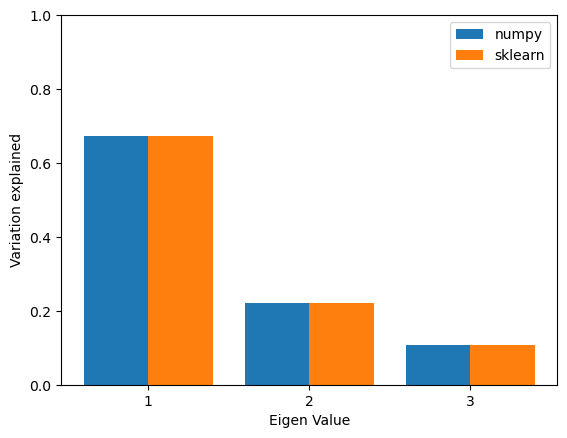

In [133]:
plot_explained_variance(
    pca_np.explained_variance_ratio_, 
    pca_sk.explained_variance_ratio_, 
    label_list = ["numpy", "sklearn"]
)

Eigenvalues from both implementations are equal, respectively explained variation plots are the same.

In [134]:
eig_vectors_np

array([[-0.54468782,  0.71780374, -0.4336738 ],
       [ 0.55032503,  0.69613416,  0.46102016],
       [-0.63281715, -0.01245052,  0.77420116]])

In [135]:
eig_vectors_sk

array([[ 0.54468782, -0.55032503,  0.63281715],
       [ 0.71780374,  0.69613416, -0.01245052],
       [-0.4336738 ,  0.46102016,  0.77420116]])

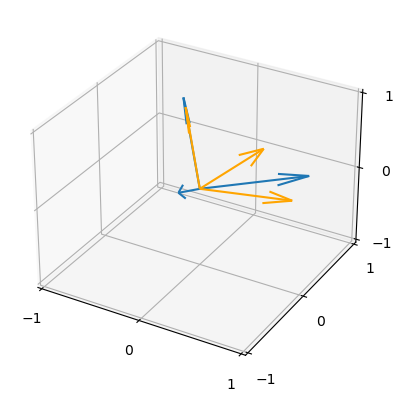

In [136]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for vec in range(3):
    ax.quiver(0, 0, 0, eig_vectors_np[0][vec], eig_vectors_np[1][vec], eig_vectors_np[2][vec])
for vec in range(3):
    ax.quiver(0, 0, 0, eig_vectors_sk[0][vec], eig_vectors_sk[1][vec], eig_vectors_sk[2][vec], color = "orange")
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-1, 0, 1])
plt.show()

In [137]:
mock_dataset_transformed_np = pca_np.transform(mock_dataset_stdr_sklearn) 
mock_dataset_transformed_np

array([[ 1.66908481, -0.76250589,  0.10039863],
       [ 1.2109677 , -0.63859801, -0.27206484],
       [ 0.63746086,  0.40839541,  1.02826268],
       [ 0.08011283, -0.39500486, -0.75442059],
       [-2.06612195, -0.53564923,  0.55548765],
       [ 0.65006425,  1.73276284, -0.25433501],
       [-2.1815685 ,  0.19059973, -0.40332852]])

In [138]:
mock_dataset_transformed_sk = pca_sk.transform(mock_dataset_stdr_sklearn)
mock_dataset_transformed_sk

array([[-1.66908481, -0.76250589,  0.10039863],
       [-1.2109677 , -0.63859801, -0.27206484],
       [-0.63746086,  0.40839541,  1.02826268],
       [-0.08011283, -0.39500486, -0.75442059],
       [ 2.06612195, -0.53564923,  0.55548765],
       [-0.65006425,  1.73276284, -0.25433501],
       [ 2.1815685 ,  0.19059973, -0.40332852]])

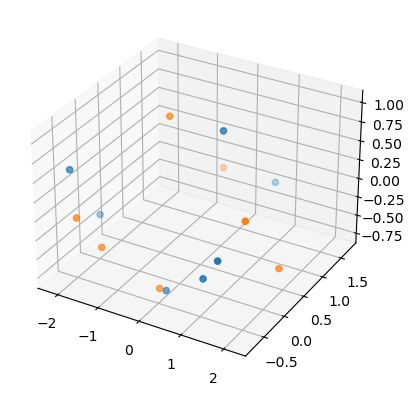

In [139]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(mock_dataset_transformed_np[:,0], mock_dataset_transformed_np[:,1], mock_dataset_transformed_np[:,2])
ax.scatter(mock_dataset_transformed_sk[:,0], mock_dataset_transformed_sk[:,1], mock_dataset_transformed_sk[:,2])
plt.show()

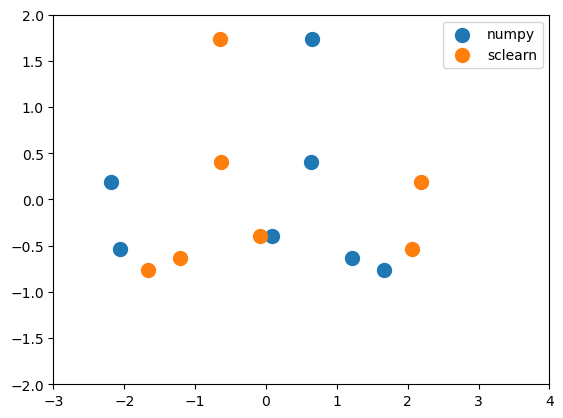

In [140]:
plt.scatter(mock_dataset_transformed_np[:,0], mock_dataset_transformed_np[:,1], 100, label = "numpy")
plt.scatter(mock_dataset_transformed_sk[:,0], mock_dataset_transformed_sk[:,1], 100, label = "sclearn")
plt.xlim([-3, 4])
plt.ylim([-2, 2])
plt.legend()
plt.show()

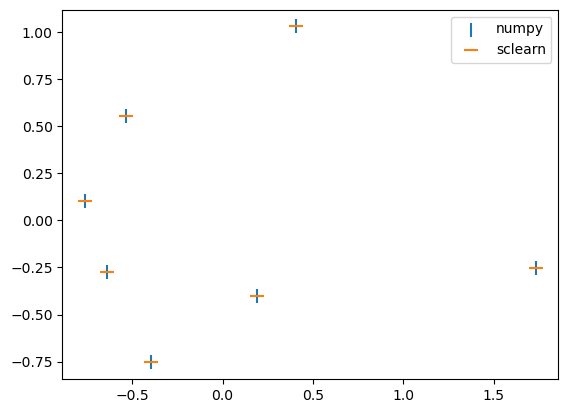

In [141]:
plt.scatter(mock_dataset_transformed_np[:,1], mock_dataset_transformed_np[:,2], 100, marker = "|", label = "numpy")
plt.scatter(mock_dataset_transformed_sk[:,1], mock_dataset_transformed_sk[:,2], 100, marker = "_", label = "sclearn")
plt.legend()
plt.show()

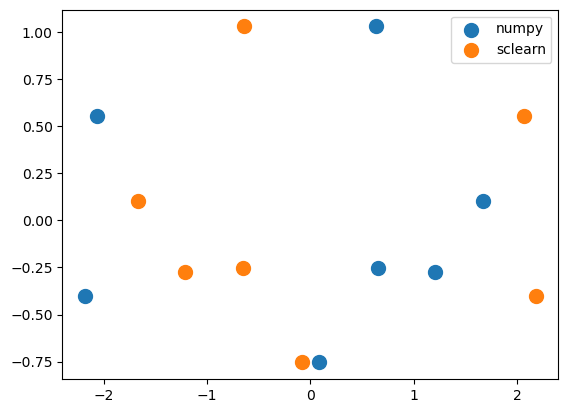

In [142]:
plt.scatter(mock_dataset_transformed_np[:,0], mock_dataset_transformed_np[:,2], 100, label = "numpy")
plt.scatter(mock_dataset_transformed_sk[:,0], mock_dataset_transformed_sk[:,2], 100, label = "sclearn")
plt.legend()
plt.show()

Projections in two of the planes defined by the principal components are mirrored and in one are equal.

##### Compare with sklearn on Iris dataset

In [143]:
iris = load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

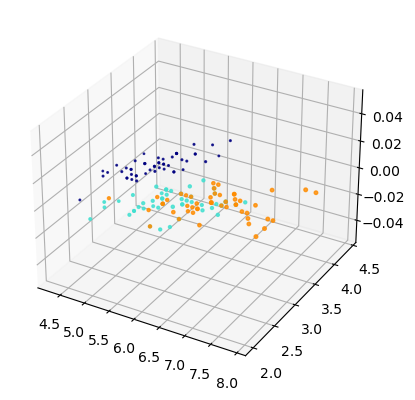

In [144]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for color, i, target_name in zip(["navy", "turquoise", "darkorange"], [0, 1, 2], target_names):
    plt.scatter(
        X[y == i,0], X[y == i,1], X[y == i,2], color=color, alpha=0.8, label=target_name
    )
plt.show()

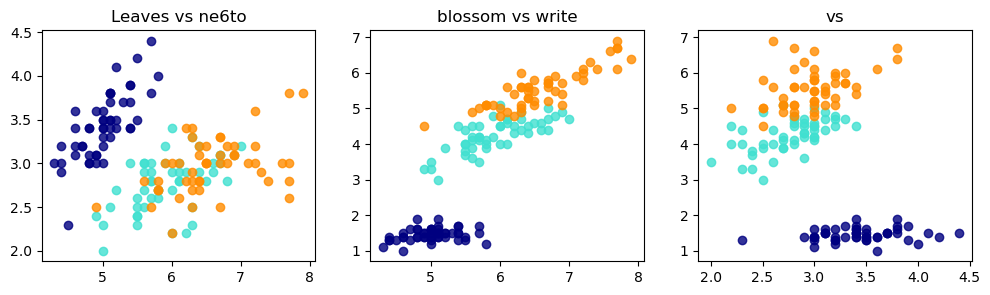

In [145]:
colors = ["navy", "turquoise", "darkorange"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 3))

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    ax1.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=0.8, label=target_name)
ax1.set_title("Leaves vs ne6to")

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    ax2.scatter(X[y == i, 0], X[y == i, 2], color=color, alpha=0.8, label=target_name)
ax2.set_title("blossom vs write")

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    ax3.scatter(X[y == i, 1], X[y == i, 2], color=color, alpha=0.8, label=target_name)
ax3.set_title("vs")

plt.show()


In [146]:
pca_iris_sk = PCA(n_components=2)
X_r = pca_iris_sk.fit(X).transform(X)

pca_iris_np = PCA_np(n_components=2)
pca_iris_np.fit(X)
X_r_np = pca_iris_np.transform(X)

In [147]:
X_r_np = X_r_np

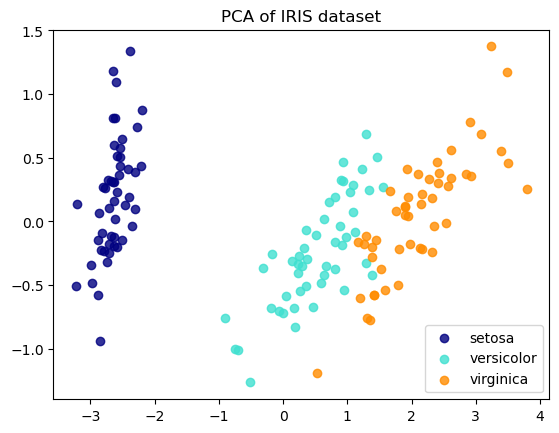

In [148]:
plt.figure()
colors = ["navy", "turquoise", "darkorange"]
colors_np = ["darkgreen", "green", "red"]

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, label=target_name
    )
    
    
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of IRIS dataset")


plt.show()

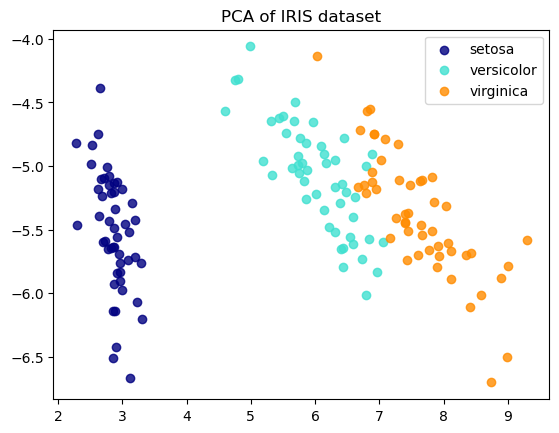

In [149]:
plt.figure()

colors_np = ["navy", "turquoise", "darkorange"]
    
for color, i, target_name in zip(colors_np, [0, 1, 2], target_names):
    plt.scatter(
        X_r_np[y == i, 0], X_r_np[y == i, 1], color=color, alpha=0.8, label=target_name
    )
    
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of IRIS dataset")


plt.show()

In [150]:
pca_iris_sk.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

In [151]:
pca_iris_np.components_.T

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [-0.65658877, -0.73016143,  0.17337266,  0.07548102]])

### PCA advantages and limitations

[advantages and limitations](https://www.keboola.com/blog/pca-machine-learning)

Since Principal component analysis is based on linear algebra it has low computational complexity, it is fast and can be applied on big datasets. Sklearn's implementation makes it easily accessible. Very useful for high-dimensional data - dimensionality reduction can speed up other machine learning algorithms, prevents overfitting, aids the visual representation and finding patterns in data. There is a trade-off between information loss and dimensionality reduction, but in many cases PCA offers considerable reduction with minimal loss.

However PCA has it's limitations. Low interpretability of the principal components can be an issue. The algorithm assumes a linear correlation between features. If there is no such corelation or it is weak PCA can still be applied, but it won't be efficient. Application on datasets with many indicator variables is usually not efficient either. PCA is sensitive to the scale of the features, which is why standardization of the variables is very important.
PCA is not robust against outliers, and removing outliers before performing PCA is advised. Since the goal of PCA is the projection with highest possible variance, it could also be the projection with highest rate of noise. Most of the implementations often assume no missing values.

We explore applying PCA on datasets with presumably bad feature characteristics - non-linear and  weak correlations.


#### Non-linear correlations

Since principal components are computed as linear combinations of the initial variables, non-linear correlations (higher order, exponential, trigonometric) are ignored when applying PCA. Let us compare two examples one with dataset with linear and one with non-linear correlations between the features.

We devise a mock dataset where the first variable consists of integers and the other features are linear functions of the first.

In [152]:
f1 = np.arange(6)
mock_ds_lin = np.stack([f1, f1 * 2, f1 * 5, f1 * 0.5, f1 * 0.3], axis = 1)
np.set_printoptions(suppress=True)
print(mock_ds_lin)

[[ 0.   0.   0.   0.   0. ]
 [ 1.   2.   5.   0.5  0.3]
 [ 2.   4.  10.   1.   0.6]
 [ 3.   6.  15.   1.5  0.9]
 [ 4.   8.  20.   2.   1.2]
 [ 5.  10.  25.   2.5  1.5]]


And a similar dataset, but one with non-linear functions.

In [153]:
f1 = f1 # same first column
f2 = f1 ** 3
f3 = np.sin(f1)
f4 = np.e ** f1
f5 = np.sqrt(f1)


In [154]:
mock_ds_nonlin = np.stack([f1, f2, f3, f4, f5], axis = 1)
print(mock_ds_nonlin)

[[  0.           0.           0.           1.           0.        ]
 [  1.           1.           0.84147098   2.71828183   1.        ]
 [  2.           8.           0.90929743   7.3890561    1.41421356]
 [  3.          27.           0.14112001  20.08553692   1.73205081]
 [  4.          64.          -0.7568025   54.59815003   2.        ]
 [  5.         125.          -0.95892427 148.4131591    2.23606798]]


We scale both:

In [155]:
scaler_lin = StandardScaler()
scaler_nonlin = StandardScaler()

In [156]:
mock_ds_lin_scaled = scaler_lin.fit_transform(mock_ds_lin)
mock_ds_lin_scaled

array([[-1.46385011, -1.46385011, -1.46385011, -1.46385011, -1.46385011],
       [-0.87831007, -0.87831007, -0.87831007, -0.87831007, -0.87831007],
       [-0.29277002, -0.29277002, -0.29277002, -0.29277002, -0.29277002],
       [ 0.29277002,  0.29277002,  0.29277002,  0.29277002,  0.29277002],
       [ 0.87831007,  0.87831007,  0.87831007,  0.87831007,  0.87831007],
       [ 1.46385011,  1.46385011,  1.46385011,  1.46385011,  1.46385011]])

In [157]:
mock_ds_nonlin_scaled = scaler_nonlin.fit_transform(mock_ds_nonlin)
mock_ds_nonlin_scaled

array([[-1.46385011, -0.8358308 , -0.04123458, -0.72900337, -1.8868169 ],
       [-0.87831007, -0.81354198,  1.14055624, -0.69606883, -0.53624991],
       [-0.29277002, -0.65752023,  1.23581403, -0.60654347,  0.02317326],
       [ 0.29277002, -0.23403262,  0.15695922, -0.36318832,  0.45243375],
       [ 0.87831007,  0.59065376, -1.10411406,  0.29831956,  0.81431709],
       [ 1.46385011,  1.95027186, -1.38798084,  2.09648443,  1.13314271]])

Compute the covariance matrices: 

In [158]:
np.cov(mock_ds_lin_scaled, rowvar = False)

array([[1.2, 1.2, 1.2, 1.2, 1.2],
       [1.2, 1.2, 1.2, 1.2, 1.2],
       [1.2, 1.2, 1.2, 1.2, 1.2],
       [1.2, 1.2, 1.2, 1.2, 1.2],
       [1.2, 1.2, 1.2, 1.2, 1.2]])

In [159]:
np.cov(mock_ds_nonlin_scaled, rowvar = False)

array([[ 1.2       ,  1.08714808, -0.8517615 ,  1.01614381,  1.14653188],
       [ 1.08714808,  1.2       , -1.02036413,  1.18486707,  0.91662323],
       [-0.8517615 , -1.02036413,  1.2       , -0.96193705, -0.58120978],
       [ 1.01614381,  1.18486707, -0.96193705,  1.2       ,  0.83778625],
       [ 1.14653188,  0.91662323, -0.58120978,  0.83778625,  1.2       ]])

Although the correlation between the variables is non linear, the covariation is quite high, so we presume PCA can be efficiently applied.

In [160]:
pca_lin = PCA_np()
pca_lin.fit(mock_ds_lin_scaled)
pca_lin.explained_variance_

array([ 6.,  0.,  0., -0., -0.])

In [161]:
pca_lin.components_

array([[-0.4472136 , -0.09128709, -0.89442719, -0.67936707, -0.3354102 ],
       [-0.4472136 , -0.09128709,  0.2236068 ,  0.46401547, -0.3354102 ],
       [-0.4472136 , -0.54772256,  0.2236068 ,  0.07178387,  0.78262379],
       [-0.4472136 , -0.09128709,  0.2236068 , -0.32044774, -0.3354102 ],
       [-0.4472136 ,  0.82158384,  0.2236068 ,  0.46401547,  0.2236068 ]])

In [162]:
pca_nonlin = PCA_np()
pca_nonlin.fit(mock_ds_nonlin_scaled)
pca_nonlin.explained_variance_

array([5.06355133, 0.72573124, 0.20791481, 0.00266241, 0.00014021])

In [163]:
pca_nonlin.components_

array([[ 0.46893831,  0.32053494, -0.22232581, -0.79163128, -0.03528965],
       [ 0.47929896, -0.15834797,  0.29748312,  0.17156585, -0.79200213],
       [-0.40718483,  0.61861794,  0.63054668, -0.16032007, -0.16799022],
       [ 0.4615227 , -0.21343329,  0.65183996, -0.02115735,  0.56222776],
       [ 0.41420608,  0.66628923, -0.19897381,  0.56367979,  0.16482261]])

We show explained variance of both datasets on the same plot:

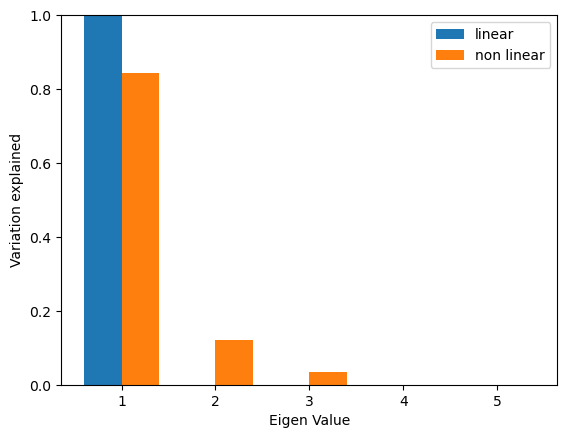

In [164]:
plot_explained_variance(
    pca_lin.explained_variance_ratio_, 
    pca_nonlin.explained_variance_ratio_, 
    label_list = ["linear", "non linear"]
)

As expected, when the features are linearly dependent, data can be described with only one eigenvector. Even if their corelation is non linear, when covariance is high data can be described by a small number of principal components. For our non linear mock dataset 3 out of 5 are enough for lossless dimensionality reduction. In general the higher the covariance - the more efficient PCA is.


#### Weak relationship between features

If the relationship between variables is weak, PCA does not work well to reduce data. It is considered that if most of the correlation coefficients are smaller than 0.3, PCA would not be efficient for dimensionality reduction [weak relation reference](https://www.originlab.com/doc/Origin-Help/PrincipleComp-Analysis#:~:text=PCA%20should%20be%20used%20mainly,0.3%2C%20PCA%20will%20not%20help.).

Let's compute an array that satisfies the condition for weak correlation and apply PCA on it. 

<sub>Honorable mention of ChatGPT, would have never thought of using brute force for acquiring a dataset.</sub>

In [165]:
np.random.seed(42) # Fixing random state for reproducibility

while True:

    arr = np.random.rand(5, 5)  # Create a 5 x 5 array with random values between 0 and 1
    cov_matrix = np.cov(arr.T)  # Compute the covariance matrix of the array

    if np.all(cov_matrix < 0.3):  # Check if all values in the covariance matrix are less than 0.3
        print("Found an array with covariance under 0.3 for all columns:")
        break
arr

Found an array with covariance under 0.3 for all columns:


array([[0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864],
       [0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258],
       [0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497],
       [0.18340451, 0.30424224, 0.52475643, 0.43194502, 0.29122914],
       [0.61185289, 0.13949386, 0.29214465, 0.36636184, 0.45606998]])

In [166]:
mock_ds_weak = arr

In [167]:
cov_weak = np.cov(mock_ds_weak.T)
cov_weak

array([[ 0.05262338, -0.03151218, -0.04326695,  0.007633  ,  0.00555633],
       [-0.03151218,  0.19658288,  0.04516089, -0.01959609, -0.08768978],
       [-0.04326695,  0.04516089,  0.0576214 ,  0.00841726,  0.0000609 ],
       [ 0.007633  , -0.01959609,  0.00841726,  0.02710645,  0.01444338],
       [ 0.00555633, -0.08768978,  0.0000609 ,  0.01444338,  0.05211473]])

In [168]:
scaler_weak = StandardScaler()

In [169]:
mock_ds_weak_scaled = scaler_nonlin.fit_transform(mock_ds_weak)
mock_ds_weak_scaled

array([[ 0.51303718,  1.17565043,  0.38421172,  1.06326126, -0.99235382],
       [-0.55210525, -1.07523801,  1.00918004,  1.07994296,  1.71133228],
       [-1.21206347,  1.22405459,  0.85206254, -1.56014284, -0.86596724],
       [-0.41851509, -0.45451589, -0.58101971, -0.06885072, -0.33015992],
       [ 1.66964664, -0.86995111, -1.66443459, -0.51421065,  0.47714869]])

In [170]:
pca_weak = PCA_np()
pca_weak.fit(mock_ds_weak_scaled)
pca_weak.explained_variance_

array([2.94189146, 2.0165846 , 1.08500673, 0.20651721, 0.        ])

In [171]:
pca_weak.components_

array([[-0.44292462,  0.45510774,  0.41688883,  0.56789115,  0.31685654],
       [ 0.58690643,  0.18915052,  0.35262306,  0.3784374 , -0.59346865],
       [ 0.40033552, -0.60213108,  0.09216732,  0.42982427,  0.53284699],
       [-0.25665534, -0.42926637,  0.77985848, -0.34610199, -0.14796145],
       [-0.48292663, -0.45854941, -0.29186747,  0.4793217 , -0.49150625]])

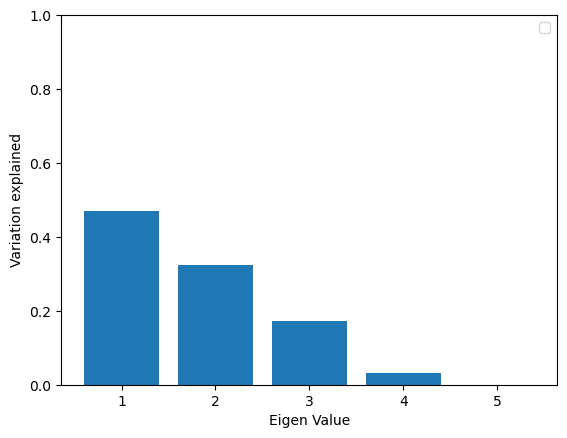

In [172]:
plot_explained_variance(pca_weak.explained_variance_ratio_)

For our week relation mock dataset we need 4 out of 5 principal components to fully describe the data. Discarding small number of principal components leads to big information loss. 

#### Kernel and sparce PCA

One way of extending the PCA method to deal with non-linear problems is Kernel PCA. The basic idea behind kernel methods is to implicitly map the data points into a higher-dimensional space where linear relationships may exist. This mapping is achieved through a kernel function that measures the similarity or distance between data points in the original space. Commonly used kernels are linear (hyperplane described with linear combinations of feature vectors), polynomial (polynomial of chosen degree of feature vectors), Gaussian (RBF) (exponential of the negative squared Euclidean distance between feature vectors), Sigmoid (hyperbolic tangent of the dot product of feature vectors, scaled by a slope parameter and an offset term), Laplacian (exponential of the negative L1 distance between feature vectors).

Traditional PCA uses all features in computing the principal components of a dataset. However, in some cases, it may be desirable to obtain sparse principal components, where only a subset of the original features is used. This is known as Sparse PCA. The goal is to find a sparse linear combination of the original features that explains the most variance in the data. By encouraging sparsity, sparse PCA can identify a small number of important features while disregarding the less relevant ones. 

## PCA Aplications

### Dimentionality reduction - Recepies

Cutest analogy for PCA I came across while researching the algorithm stated that initial variables can be thought of as ingredients in a recipe - flour, eggs, sugar and the dataset is then described in terms of pancakes. This is not entirely accurate, but it is a good starting point of understanding the method. This is where the idea of applying PCA on recipe ingredients dataset came from. 
Source of the dataset is [Kaggle](https://www.kaggle.com/datasets/kaggle/recipe-ingredients-dataset). It contains id, type of cuisine and ingredients list for 39774 recipes. We treat each ingredient as an indicator variable and our goal is to reduce the dimensionality so that a visual representation of the dataset is possible.

In [173]:
recipes = pd.read_json("kaggle_data/train.json")
recipes

id      cuisine                                        ingredients
0      10259        greek  [romaine lettuce, black olives, grape tomatoes...
1      25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2      20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3      22213       indian                [water, vegetable oil, wheat, salt]
4      13162       indian  [black pepper, shallots, cornflour, cayenne pe...
...      ...          ...                                                ...
39769  29109        irish  [light brown sugar, granulated sugar, butter, ...
39770  11462      italian  [KRAFT Zesty Italian Dressing, purple onion, b...
39771   2238        irish  [eggs, citrus fruit, raisins, sourdough starte...
39772  41882      chinese  [boneless chicken skinless thigh, minced garli...
39773   2362      mexican  [green chile, jalapeno chilies, onions, ground...

[39774 rows x 3 columns]

In [174]:
num_rows = recipes.shape[0]
num_rows

39774

In [175]:
dict_ing = {} # Dict to store all unique ingredients and their occurrences

In [176]:
for line in recipes.ingredients: # Iterating through all entries of the dataset
    for ing in line: # Iterates the ingredients in the list
        if ing not in dict_ing:
            dict_ing[ing] = 0
        dict_ing[ing] += 1

In [177]:
dict_ing

{'romaine lettuce': 270,
 'black olives': 229,
 'grape tomatoes': 228,
 'garlic': 7380,
 'pepper': 4438,
 'purple onion': 1896,
 'seasoning': 137,
 'garbanzo beans': 148,
 'feta cheese crumbles': 358,
 'plain flour': 154,
 'ground pepper': 385,
 'salt': 18049,
 'tomatoes': 3058,
 'ground black pepper': 4785,
 'thyme': 361,
 'eggs': 3388,
 'green tomatoes': 108,
 'yellow corn meal': 341,
 'milk': 2263,
 'vegetable oil': 4385,
 'mayonaise': 781,
 'cooking oil': 483,
 'green chilies': 768,
 'grilled chicken breasts': 5,
 'garlic powder': 1442,
 'yellow onion': 1184,
 'soy sauce': 3296,
 'butter': 4848,
 'chicken livers': 65,
 'water': 7457,
 'wheat': 26,
 'black pepper': 2627,
 'shallots': 1477,
 'cornflour': 103,
 'cayenne pepper': 1523,
 'onions': 7972,
 'garlic paste': 282,
 'lemon juice': 1395,
 'chili powder': 2036,
 'passata': 24,
 'oil': 1970,
 'ground cumin': 2747,
 'boneless chicken skinless thigh': 343,
 'garam masala': 925,
 'double cream': 40,
 'natural yogurt': 18,
 'bay leaf

In [178]:
len(dict_ing) # Number of unique ingredients

6714

In [179]:
sorted_list = sorted(dict_ing.items(), key=lambda x:x[1], reverse=True) # Sort by frequency in descending order
sorted_titles = [x[0] for x in sorted_list if x[1] > 200] # List of ingredient names with more than 200 occurrences
len(sorted_titles)

387

In [180]:
ingredients_df = pd.DataFrame(0, index=np.arange(num_rows), columns=sorted_titles) # Creates dataframe of zeroes with column for each ingredient name

In [181]:
for row in range(num_rows): 
    for ingredient in recipes.at[row, "ingredients"]:
        if ingredient in ingredients_df.columns:
            ingredients_df.at[row, ingredient] = 1     # Changes the 0 to 1 if ingredient is present in the recipe 


In [182]:
ingredients_df.shape

(39774, 387)

In [183]:
ingredients_df

salt  onions  olive oil  water  garlic  sugar  garlic cloves  butter   
0         0       0          0      0       1      0              0       0  \
1         1       0          0      0       0      0              0       0   
2         1       0          0      0       0      0              0       1   
3         1       0          0      1       0      0              0       0   
4         1       1          0      1       0      0              0       1   
...     ...     ...        ...    ...     ...    ...            ...     ...   
39769     1       0          0      0       0      0              0       1   
39770     0       0          0      0       0      0              0       0   
39771     1       0          0      0       0      1              0       1   
39772     0       0          0      0       0      1              0       0   
39773     1       1          0      0       1      0              0       0   

       ground black pepper  all-purpose flour  ...  chives  saffron   
0                        0                  0  ...       0        0  \
1                        1                  0  ...       0        0   
2                        0                  0  ...       0        0   
3                        0                  0  ...       0        0   
4                        0                  0  ...       0        0   
...                    ...                ...  ...     ...      ...   
39769                    0                  1  ...       0        0   
39770                    0                  0  ...       0        0   
39771                    0                  0  ...       0        0   
39772                    0                  0  ...       0        0   
39773                    1                  0  ...       0        0   

       frozen chopped spinach  fennel bulb  red potato   
0                           0            0           0  \
1                           0            0           0   
2                           0            0           0   
3                           0            0           0   
4                           0            0           0   
...                       ...          ...         ...   
39769                       0            0           0   
39770                       0            0           0   
39771                       0            0           0   
39772                       0            0           0   
39773                       0            0           0   

       pitted kalamata olives  cannellini beans  beer  brown rice   
0                           0                 0     0           0  \
1                           0                 0     0           0   
2                           0                 0     0           0   
3                           0                 0     0           0   
4                           0                 0     0           0   
...                       ...               ...   ...         ...   
39769                       0                 0     0           0   
39770                       0                 0     0           0   
39771                       0                 0     0           0   
39772                       0                 0     0           0   
39773                       0                 0     0           0   

       dark sesame oil  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
39769                0  
39770                0  
39771                0  
39772                0  
39773                0  

[39774 rows x 387 columns]

In [184]:
pca_ingredients = PCA(2)

In [185]:
ingredients_transformed = pca_ingredients.fit_transform(ingredients_df)

In [186]:
ingredients_transformed.shape

(39774, 2)

In [187]:
cuisine_list = recipes['cuisine']. unique()
cuisine_list

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [188]:
n_types = len(cuisine_list)
n_types

20

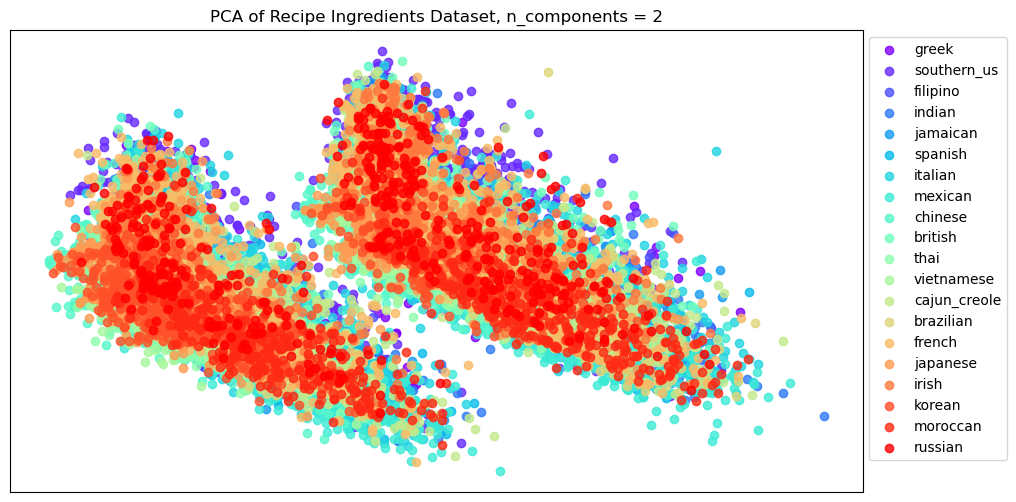

In [189]:
plt.figure(figsize=(11,6))

colormap = plt.cm.rainbow(np.linspace(0, 1, len(cuisine_list)))

for i, cuisine_type in enumerate(cuisine_list):
    plt.scatter(
        ingredients_transformed[recipes["cuisine"] == cuisine_type, 0], 
        ingredients_transformed[recipes["cuisine"] == cuisine_type, 1], 
        alpha=0.8, 
        label=cuisine_type,
        color = colormap[i]
    )
    
plt.xticks([])
plt.yticks([])
plt.legend(bbox_to_anchor=(1, 1), shadow=False, scatterpoints=1)
plt.title("PCA of Recipe Ingredients Dataset, n_components = 2")


plt.show()

On the 2D plot we can observe two distinct groups of datapoints. By applying PCA on our dataset we achieved quick and easy dimensionality reduction from 387 to 2 variables, which allowed us to visualize the data and find this pattern.

In [190]:
pca_ingredients_3 = PCA(3)
ingredients_transformed = pca_ingredients_3.fit_transform(ingredients_df)

C:\Users\diana\anaconda3\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


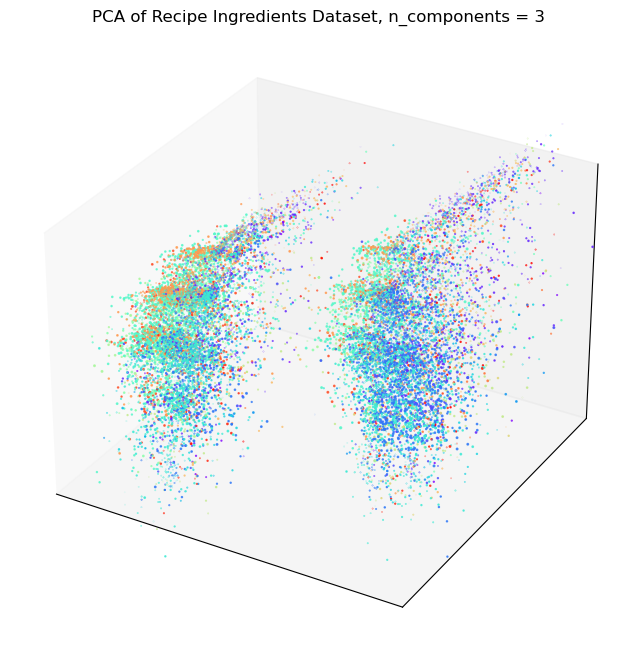

In [191]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(projection='3d')

for i, cuisine_type in enumerate(cuisine_list):
    plt.scatter(
        ingredients_transformed[recipes["cuisine"] == cuisine_type, 0], 
        ingredients_transformed[recipes["cuisine"] == cuisine_type, 1],
        ingredients_transformed[recipes["cuisine"] == cuisine_type, 2],
        alpha=0.8, 
        label=cuisine_type,
        color = colormap[i]
    )

ax.set_xlim([-1, 1])
ax.set_ylim([-0.5, 1])
ax.set_zlim([-0.2, 0.1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.title("PCA of Recipe Ingredients Dataset, n_components = 3")

plt.show()


The two distinct groups of datapoints are also clearly observable in the 3D plot. Sadly PCA cannot answer the question why is this separation occurring and further research is needed, which is outside of the scope of the current article. 

### Image compression - Rose image

Another useful application of PCA is image compression. This section is based on [this article](https://towardsdatascience.com/dimensionality-reduction-of-a-color-photo-splitting-into-rgb-channels-using-pca-algorithm-in-python-ba01580a1118) using a rose image from [here](https://p1.pxfuel.com/preview/31/778/511/rosa-beautiful-rose-flower-nature.jpg) and without using open cv.

In [192]:
# helper functions
def read_image(url):
    img = skimage.io.imread(url)
    return img

def plot_image(image, ax = None, cmap = None, show = True):
    ax = ax or plt.gca()
    ax.imshow(image, cmap = cmap)
    ax.axis("off")
    
    if show:
        plt.show()

In [193]:
rose_image_raw = read_image("rosa-beautiful-rose-flower-nature.jpg") # read the image with sklearn

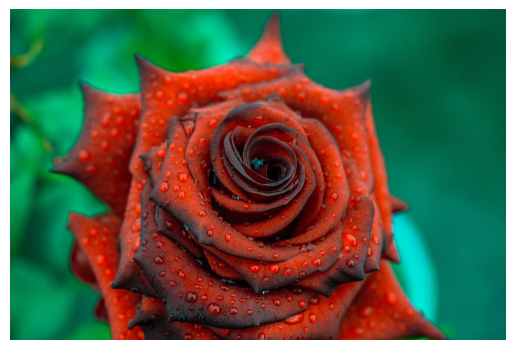

In [194]:
plot_image(rose_image_raw) # Plot original image

In [195]:
rose_image_raw.shape

(607, 910, 3)

In [196]:
rose_image_r, rose_image_g, rose_image_b = [rose_image_raw[:, :, i] for i in range(3)] # Split channels

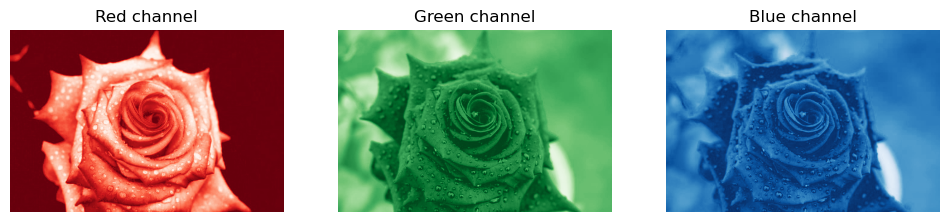

In [197]:
f, (ax_r, ax_g, ax_b) = plt.subplots(1, 3, figsize = (12, 5))
plot_image(rose_image_r, ax = ax_r, cmap = "Reds_r", show = False)
ax_r.set_title("Red channel")


plot_image(rose_image_g, ax = ax_g, cmap = "Greens_r", show = False)
ax_g.set_title("Green channel")

plot_image(rose_image_b, ax = ax_b, cmap = "Blues_r", show = False)
ax_b.set_title("Blue channel")


plt.show()

In [198]:
# Normalize the image
rose_image_r_normalized, rose_image_g_normalized, rose_image_b_normalized = [
    channel / 255 for channel in [rose_image_r, rose_image_g, rose_image_b]
]

In [199]:
rose_image_r_normalized.shape, rose_image_g_normalized.shape, rose_image_b_normalized.shape

((607, 910), (607, 910), (607, 910))

In [200]:
# Apply PCA separately on each channel

pca_r = PCA()
pca_r.fit(rose_image_r_normalized)
trans_pca_r = pca_r.transform(rose_image_r_normalized)

pca_g = PCA()
pca_g.fit(rose_image_g_normalized)
trans_pca_g = pca_g.transform(rose_image_g_normalized)

pca_b = PCA()
pca_b.fit(rose_image_b_normalized)
trans_pca_b = pca_b.transform(rose_image_b_normalized)


We plot the explained variance ratio of the first 31 eigenvalues, this is entirely for better visualisation, all calculations are done with all 607 principal components.

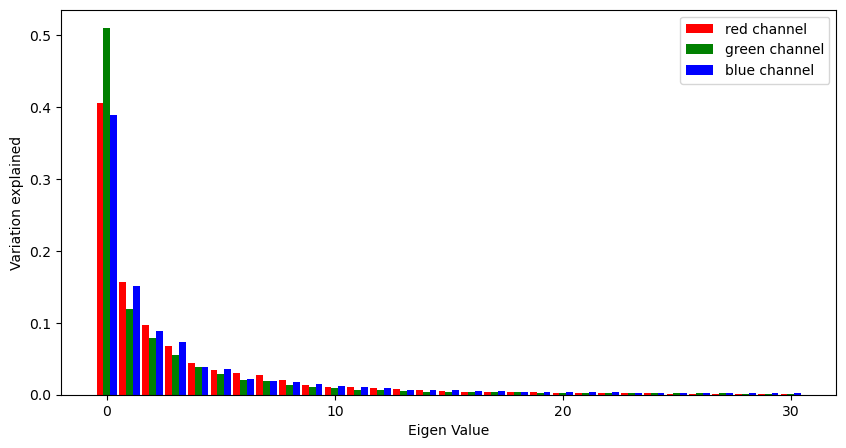

In [201]:
n_plot = 31   
num_eigenvalues = np.arange(0, n_plot)


plt.figure(figsize=(10, 5))
plt.bar(-0.3 + num_eigenvalues, pca_r.explained_variance_ratio_[:n_plot], 0.3, color = "red", label = "red channel")
plt.bar(0 + num_eigenvalues, pca_g.explained_variance_ratio_[:n_plot], 0.3, color = "green", label = "green channel")
plt.bar(0.3 + num_eigenvalues, pca_b.explained_variance_ratio_[:n_plot], 0.3, color = "blue", label = "blue channel")
    
plt.xlabel('Eigen Value')
plt.ylabel('Variation explained')
plt.xticks(np.arange(0, n_plot, 10))

plt.legend()

plt.show()

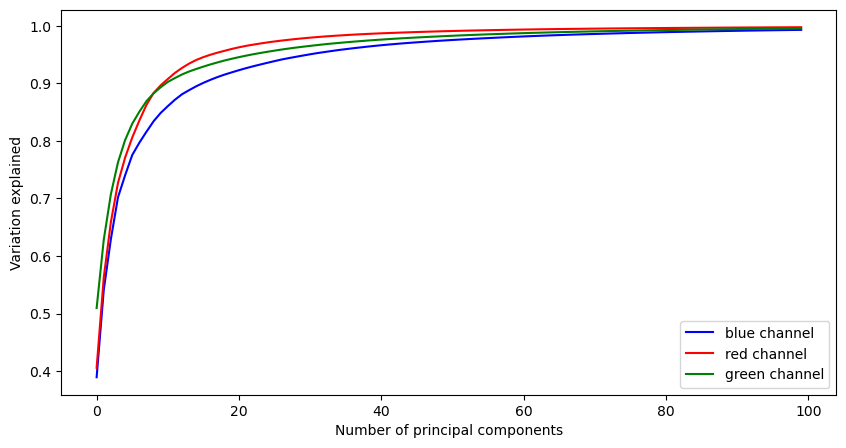

In [202]:
plt.figure(figsize=(10, 5))

n_plot = 100   
num_eigenvalues = np.arange(0, n_plot)

plt.plot(num_eigenvalues, pca_b.explained_variance_ratio_[:n_plot].cumsum(), color = "blue", label = "blue channel")
plt.plot(num_eigenvalues, pca_r.explained_variance_ratio_[:n_plot].cumsum(), color = "red", label = "red channel")
plt.plot(num_eigenvalues, pca_g.explained_variance_ratio_[:n_plot].cumsum(), color = "green", label = "green channel")

plt.xlabel('Number of principal components')
plt.ylabel('Variation explained')
plt.legend()

plt.show()


In [203]:
def compress_rose_image(n_components):
    pca_r = PCA(n_components)
    trans_pca_r = pca_r.fit_transform(rose_image_r_normalized)
    
    pca_g = PCA(n_components)
    trans_pca_g = pca_g.fit_transform(rose_image_g_normalized)

    pca_b = PCA(n_components)
    trans_pca_b = pca_b.fit_transform(rose_image_b_normalized)
    
    
    b_arr = pca_b.inverse_transform(trans_pca_b)
    g_arr = pca_g.inverse_transform(trans_pca_g)
    r_arr = pca_r.inverse_transform(trans_pca_r)
    
    rose_image_reduced = np.array([r_arr, g_arr, b_arr])
    rose_image_reduced = np.moveaxis(rose_image_reduced, 0, 2)
    
    assert rose_image_reduced.shape == rose_image_raw.shape, "Shape doesn't match"
    
    return rose_image_reduced
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


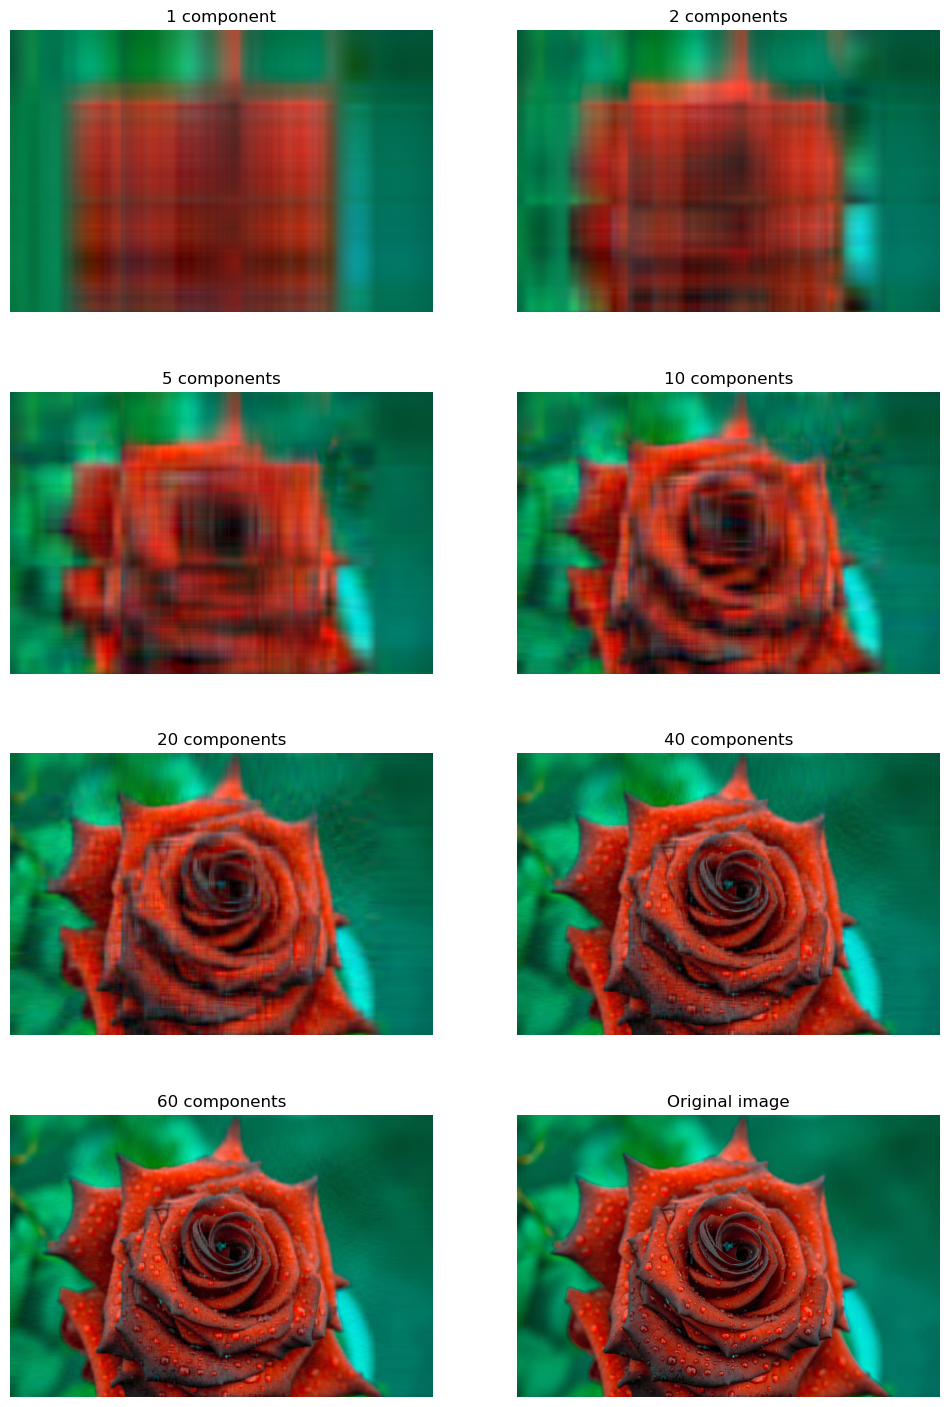

In [204]:
n_components_list = [1, 2, 5, 10, 20, 40, 60]

fig = plt.figure(figsize=(12, 18))
for i in range(7):
    rose_image_compressed = compress_rose_image(n_components_list[i])
    ax = plt.subplot(4, 2, i+1)
    plot_image(rose_image_compressed, ax = ax, show = False)
    ax.set_title(f"{n_components_list[i]} components")
    if i == 0:
        ax.set_title("1 component")

ax = plt.subplot(4, 2, 8)
plot_image(rose_image_raw, ax = ax, show = False)
ax.set_title("Original image")

plt.show()




At one and two principal components kept, our image is a colorful blob, but at 5 it is already recognizable, at 10 it is still somewhat blurry but has good resemblance, at 20 and 40 components the image is not very visually appealing but is very close representation of the original image. At 60 components (out of 607) it is undistinguishable from the original, at least for our plot resolution. 
In conclusion PCA would not be the first choice for image decompression when the goal is esthetics, but can greatly shorten conversion time of image-related machine learning algorithms.

## Eigenpets

#####  <i> Eigen this and eigen that, eigendog und eigencat </i>

In [205]:
cats = pd.read_csv("https://raw.githubusercontent.com/bioramble/pca/master/cat.csv", header=None)
cats = cats / 255 # Normalise
cats

0         1         2         3         4         5         6    
0     0.250980  0.090196  0.980392  0.537255  0.215686  0.678431  0.070588  \
1     0.250980  0.090196  0.980392  0.537255  0.215686  0.678431  0.070588   
2     0.250980  0.078431  0.980392  0.537255  0.215686  0.678431  0.070588   
3     0.250980  0.078431  0.956863  0.564706  0.215686  0.678431  0.050980   
4     0.250980  0.035294  0.956863  0.592157  0.215686  0.619608  0.050980   
...        ...       ...       ...       ...       ...       ...       ...   
4091  0.301961  0.254902  0.956863  0.305882  0.176471  0.301961  0.274510   
4092  0.301961  0.200000  0.956863  0.392157  0.176471  0.384314  0.274510   
4093  0.250980  0.121569  0.956863  0.400000  0.145098  0.250980  0.243137   
4094  0.250980  0.090196  0.909804  0.486275  0.176471  0.176471  0.243137   
4095  0.239216  0.035294  0.956863  0.486275  0.203922  0.176471  0.274510   

            7         8         9   ...        70        71        72   
0     0.525490  0.074510  0.184314  ...  0.478431  0.070588  0.341176  \
1     0.525490  0.074510  0.172549  ...  0.462745  0.145098  0.313725   
2     0.525490  0.074510  0.219608  ...  0.301961  0.094118  0.298039   
3     0.525490  0.074510  0.282353  ...  0.427451  0.054902  0.278431   
4     0.525490  0.074510  0.282353  ...  0.545098  0.066667  0.278431   
...        ...       ...       ...  ...       ...       ...       ...   
4091  0.447059  0.741176  0.701961  ...  0.639216  0.580392  0.203922   
4092  0.447059  0.741176  0.592157  ...  0.498039  0.580392  0.329412   
4093  0.447059  0.741176  0.317647  ...  0.572549  0.568627  0.215686   
4094  0.447059  0.741176  0.172549  ...  0.400000  0.600000  0.196078   
4095  0.447059  0.741176  0.184314  ...  0.541176  0.647059  0.254902   

            73        74        75        76        77        78        79  
0     0.415686  0.682353  0.270588  0.109804  0.235294  0.874510  0.396078  
1     0.388235  0.701961  0.278431  0.125490  0.196078  0.878431  0.419608  
2     0.223529  0.639216  0.286275  0.109804  0.247059  0.882353  0.415686  
3     0.125490  0.662745  0.298039  0.149020  0.207843  0.901961  0.411765  
4     0.415686  0.756863  0.301961  0.086275  0.168627  0.913725  0.431373  
...        ...       ...       ...       ...       ...       ...       ...  
4091  0.662745  0.125490  0.258824  0.564706  0.368627  0.721569  0.466667  
4092  0.690196  0.160784  0.254902  0.533333  0.360784  0.705882  0.505882  
4093  0.745098  0.168627  0.345098  0.552941  0.411765  0.705882  0.447059  
4094  0.729412  0.145098  0.388235  0.564706  0.462745  0.713725  0.356863  
4095  0.792157  0.133333  0.258824  0.564706  0.407843  0.694118  0.443137  

[4096 rows x 80 columns]

In [206]:
dogs = pd.read_csv("https://raw.githubusercontent.com/bioramble/pca/master/dog.csv", header=None)
dogs = dogs / 255 # normalise
dogs

0         1         2         3         4         5         6    
0     0.878431  0.513725  0.498039  0.494118  0.533333  0.066667  0.654902  \
1     0.878431  0.486275  0.533333  0.490196  0.498039  0.031373  0.654902   
2     0.878431  0.407843  0.498039  0.490196  0.498039  0.000000  0.694118   
3     0.854902  0.376471  0.533333  0.419608  0.533333  0.000000  0.647059   
4     0.878431  0.349020  0.764706  0.368627  0.600000  0.031373  0.498039   
...        ...       ...       ...       ...       ...       ...       ...   
4091  0.133333  0.486275  0.407843  0.298039  0.498039  0.000000  0.337255   
4092  0.235294  0.407843  0.407843  0.298039  0.447059  0.000000  0.368627   
4093  0.392157  0.407843  0.450980  0.298039  0.368627  0.031373  0.415686   
4094  0.392157  0.486275  0.407843  0.321569  0.368627  0.000000  0.458824   
4095  0.392157  0.486275  0.407843  0.364706  0.423529  0.000000  0.556863   

            7         8         9   ...        70        71        72   
0     0.239216  0.345098  0.721569  ...  0.003922  0.396078  0.000000  \
1     0.207843  0.345098  0.721569  ...  0.003922  0.396078  0.007843   
2     0.090196  0.333333  0.721569  ...  0.003922  0.400000  0.023529   
3     0.027451  0.345098  0.768627  ...  0.003922  0.403922  0.070588   
4     0.027451  0.333333  0.768627  ...  0.003922  0.411765  0.113725   
...        ...       ...       ...  ...       ...       ...       ...   
4091  0.027451  0.254902  0.647059  ...  0.003922  0.431373  0.007843   
4092  0.027451  0.286275  0.615686  ...  0.000000  0.431373  0.000000   
4093  0.070588  0.286275  0.615686  ...  0.000000  0.427451  0.003922   
4094  0.027451  0.286275  0.615686  ...  0.000000  0.435294  0.003922   
4095  0.027451  0.286275  0.615686  ...  0.000000  0.443137  0.003922   

            73        74        75        76        77        78        79  
0     0.003922  0.403922  0.807843  0.011765  0.023529  0.117647  0.772549  
1     0.000000  0.407843  0.807843  0.172549  0.039216  0.270588  0.780392  
2     0.000000  0.411765  0.807843  0.439216  0.023529  0.270588  0.764706  
3     0.000000  0.411765  0.788235  0.533333  0.011765  0.270588  0.764706  
4     0.003922  0.423529  0.788235  0.470588  0.015686  0.117647  0.749020  
...        ...       ...       ...       ...       ...       ...       ...  
4091  0.835294  0.513725  0.623529  0.678431  0.082353  0.623529  0.654902  
4092  0.835294  0.501961  0.658824  0.666667  0.047059  0.623529  0.639216  
4093  0.831373  0.482353  0.666667  0.752941  0.027451  0.639216  0.650980  
4094  0.839216  0.470588  0.674510  0.466667  0.039216  0.549020  0.666667  
4095  0.858824  0.478431  0.686275  0.054902  0.027451  0.549020  0.670588  

[4096 rows x 80 columns]

In [207]:
dogs.columns = list(range(80, 160))

The data matrix already is in a convenient format. Each 64 by 64 pixel image has been converted into a 4096 pixel vector and each of the 160 image vector is stacked vertically to obtain a data matrix with dimensions 4096 by 160. As you might have guessed, there are 80 cats and 80 dogs in the data set. ###rewrite

In [208]:
pets = pd.concat([cats, dogs], axis=1)
pets

0         1         2         3         4         5         6     
0     0.250980  0.090196  0.980392  0.537255  0.215686  0.678431  0.070588  \
1     0.250980  0.090196  0.980392  0.537255  0.215686  0.678431  0.070588   
2     0.250980  0.078431  0.980392  0.537255  0.215686  0.678431  0.070588   
3     0.250980  0.078431  0.956863  0.564706  0.215686  0.678431  0.050980   
4     0.250980  0.035294  0.956863  0.592157  0.215686  0.619608  0.050980   
...        ...       ...       ...       ...       ...       ...       ...   
4091  0.301961  0.254902  0.956863  0.305882  0.176471  0.301961  0.274510   
4092  0.301961  0.200000  0.956863  0.392157  0.176471  0.384314  0.274510   
4093  0.250980  0.121569  0.956863  0.400000  0.145098  0.250980  0.243137   
4094  0.250980  0.090196  0.909804  0.486275  0.176471  0.176471  0.243137   
4095  0.239216  0.035294  0.956863  0.486275  0.203922  0.176471  0.274510   

           7         8         9    ...       150       151       152   
0     0.525490  0.074510  0.184314  ...  0.003922  0.396078  0.000000  \
1     0.525490  0.074510  0.172549  ...  0.003922  0.396078  0.007843   
2     0.525490  0.074510  0.219608  ...  0.003922  0.400000  0.023529   
3     0.525490  0.074510  0.282353  ...  0.003922  0.403922  0.070588   
4     0.525490  0.074510  0.282353  ...  0.003922  0.411765  0.113725   
...        ...       ...       ...  ...       ...       ...       ...   
4091  0.447059  0.741176  0.701961  ...  0.003922  0.431373  0.007843   
4092  0.447059  0.741176  0.592157  ...  0.000000  0.431373  0.000000   
4093  0.447059  0.741176  0.317647  ...  0.000000  0.427451  0.003922   
4094  0.447059  0.741176  0.172549  ...  0.000000  0.435294  0.003922   
4095  0.447059  0.741176  0.184314  ...  0.000000  0.443137  0.003922   

           153       154       155       156       157       158       159  
0     0.003922  0.403922  0.807843  0.011765  0.023529  0.117647  0.772549  
1     0.000000  0.407843  0.807843  0.172549  0.039216  0.270588  0.780392  
2     0.000000  0.411765  0.807843  0.439216  0.023529  0.270588  0.764706  
3     0.000000  0.411765  0.788235  0.533333  0.011765  0.270588  0.764706  
4     0.003922  0.423529  0.788235  0.470588  0.015686  0.117647  0.749020  
...        ...       ...       ...       ...       ...       ...       ...  
4091  0.835294  0.513725  0.623529  0.678431  0.082353  0.623529  0.654902  
4092  0.835294  0.501961  0.658824  0.666667  0.047059  0.623529  0.639216  
4093  0.831373  0.482353  0.666667  0.752941  0.027451  0.639216  0.650980  
4094  0.839216  0.470588  0.674510  0.466667  0.039216  0.549020  0.666667  
4095  0.858824  0.478431  0.686275  0.054902  0.027451  0.549020  0.670588  

[4096 rows x 160 columns]

In [209]:
def plot_image_from_vector(vector, ax = None, show = True):
    image = np.array(vector).reshape((64, 64)).T
    
    ax = ax or plt.gca()
    ax.imshow(image, cmap = "gray")
    ax.axis("off")
    
    if show:
        plt.show

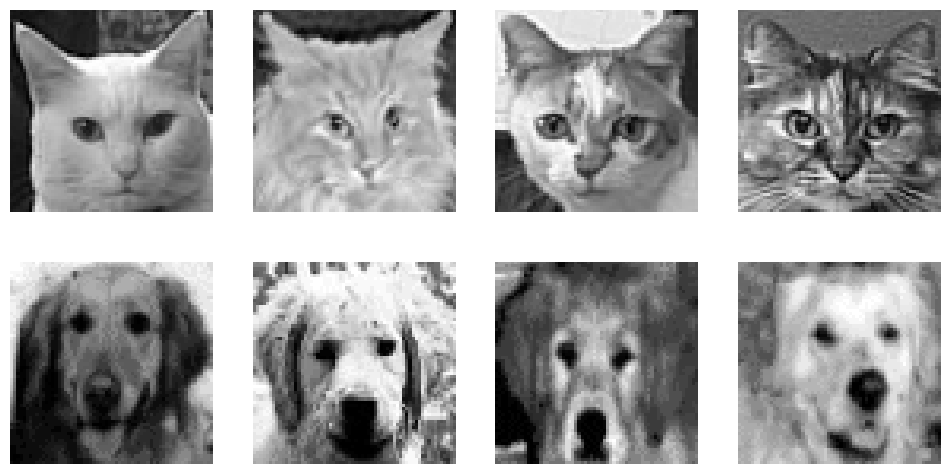

In [210]:
fig = plt.figure(figsize=(12, 6))
for i in range(8):
    ax = plt.subplot(2, 4, i+1)
    plot_image_from_vector(pets[76+i], ax = ax, show = False)

plt.show()


In [211]:
cat_mean = cats.mean(axis = 1)
dog_mean = dogs.mean(axis = 1)
pet_mean = pets.mean(axis = 1)

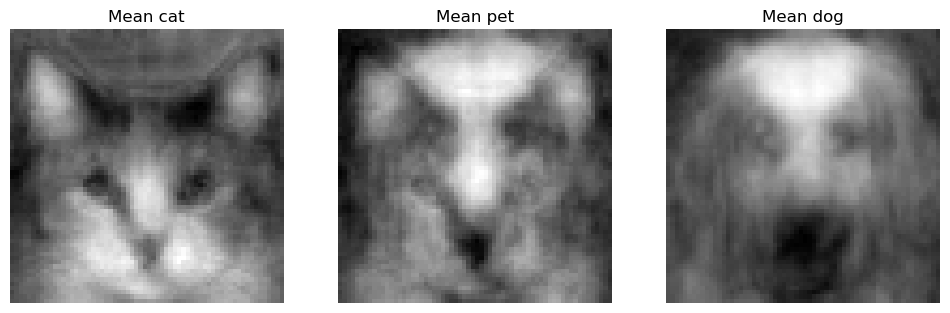

In [212]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 5))
plot_image_from_vector(cat_mean, ax = ax1, show = False)
ax1.set_title("Mean cat")

plot_image_from_vector(pet_mean, ax = ax2, show = False)
ax2.set_title("Mean pet")

plot_image_from_vector(dog_mean, ax = ax3, show = False)
ax3.set_title("Mean dog")

plt.show()


In [213]:
pets_norm = pets.sub(pet_mean, axis=0)
pets_norm

0         1         2         3         4         5         6     
0    -0.151029 -0.311814  0.578382  0.135245 -0.186324  0.276422 -0.331422  \
1    -0.141275 -0.302059  0.588137  0.145000 -0.176569  0.286176 -0.321667   
2    -0.138382 -0.310931  0.591029  0.147892 -0.173676  0.289069 -0.318775   
3    -0.137917 -0.310466  0.567966  0.175809 -0.173211  0.289534 -0.337917   
4    -0.138235 -0.353922  0.567647  0.202941 -0.173529  0.230392 -0.338235   
...        ...       ...       ...       ...       ...       ...       ...   
4091 -0.119853 -0.166912  0.535049 -0.115931 -0.245343 -0.119853 -0.147304   
4092 -0.122990 -0.224951  0.531912 -0.032794 -0.248480 -0.040637 -0.150441   
4093 -0.177819 -0.307230  0.528064 -0.028799 -0.283701 -0.177819 -0.185662   
4094 -0.175564 -0.336348  0.483260  0.059730 -0.250074 -0.250074 -0.183407   
4095 -0.187010 -0.390931  0.530637  0.060049 -0.222304 -0.249755 -0.151716   

           7         8         9    ...       150       151       152   
0     0.123480 -0.327500 -0.217696  ... -0.398088 -0.005931 -0.402010  \
1     0.133235 -0.317745 -0.219706  ... -0.388333  0.003824 -0.384412   
2     0.136127 -0.314853 -0.169755  ... -0.385441  0.010637 -0.365833   
3     0.136593 -0.314387 -0.106544  ... -0.384975  0.015025 -0.318309   
4     0.136275 -0.314706 -0.106863  ... -0.385294  0.022549 -0.275490   
...        ...       ...       ...  ...       ...       ...       ...   
4091  0.025245  0.319363  0.280147  ... -0.417892  0.009559 -0.413971   
4092  0.022108  0.316225  0.167206  ... -0.424951  0.006422 -0.424951   
4093  0.018260  0.312377 -0.111152  ... -0.428799 -0.001348 -0.424877   
4094  0.020515  0.314632 -0.253995  ... -0.426544  0.008750 -0.422623   
4095  0.020833  0.314951 -0.241912  ... -0.426225  0.016912 -0.422304   

           153       154       155       156       157       158       159  
0    -0.398088  0.001912  0.405833 -0.390245 -0.378480 -0.284363  0.370539  
1    -0.392255  0.015588  0.415588 -0.219706 -0.353039 -0.121667  0.388137  
2    -0.389363  0.022402  0.418480  0.049853 -0.365833 -0.118775  0.375343  
3    -0.388897  0.022868  0.399338  0.144436 -0.377132 -0.118309  0.375809  
4    -0.385294  0.034314  0.399020  0.081373 -0.373529 -0.271569  0.359804  
...        ...       ...       ...       ...       ...       ...       ...  
4091  0.413480  0.091912  0.201716  0.256618 -0.339461  0.201716  0.233088  
4092  0.410343  0.077010  0.233873  0.241716 -0.377892  0.198578  0.214265  
4093  0.402574  0.053554  0.237868  0.324142 -0.401348  0.210417  0.222181  
4094  0.412672  0.044044  0.247966  0.040123 -0.387328  0.122475  0.240123  
4095  0.432598  0.052206  0.260049 -0.371324 -0.398775  0.122794  0.244363  

[4096 rows x 160 columns]

In [214]:
pca_pet = PCA()

In [215]:
pets_transformed = pca_pet.fit_transform(pets_norm)
pets_transformed

array([[ 2.29295821,  2.33271157, -0.17122085, ...,  0.02566571,
         0.14265189,  0.        ],
       [ 2.38304534,  2.15911466, -0.20483086, ...,  0.0425621 ,
         0.07970643,  0.        ],
       [ 2.35643285,  2.16452486, -0.2424408 , ...,  0.06521956,
         0.01099875, -0.        ],
       ...,
       [ 0.41122186,  0.97332733, -0.92903158, ..., -0.06789161,
         0.04207222,  0.        ],
       [ 0.37904175,  0.95804362, -0.96419865, ..., -0.02782086,
         0.01452344,  0.        ],
       [ 0.32519677,  0.98587219, -0.98836518, ..., -0.0182208 ,
         0.02036288, -0.        ]])

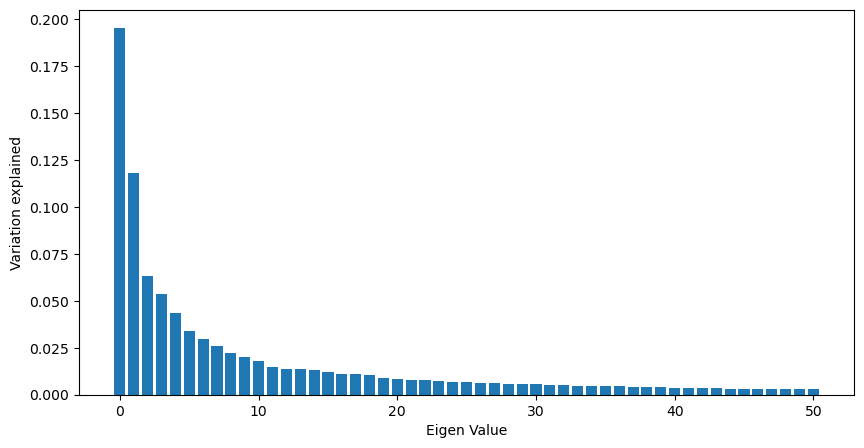

In [216]:
n_plot = 51    
num_eigenvalues = np.arange(0, n_plot)


plt.figure(figsize=(10, 5))
plt.bar(num_eigenvalues, pca_pet.explained_variance_ratio_[:n_plot])
    
plt.xlabel('Eigen Value')
plt.ylabel('Variation explained')
plt.xticks(np.arange(0, n_plot, 10))

plt.show()

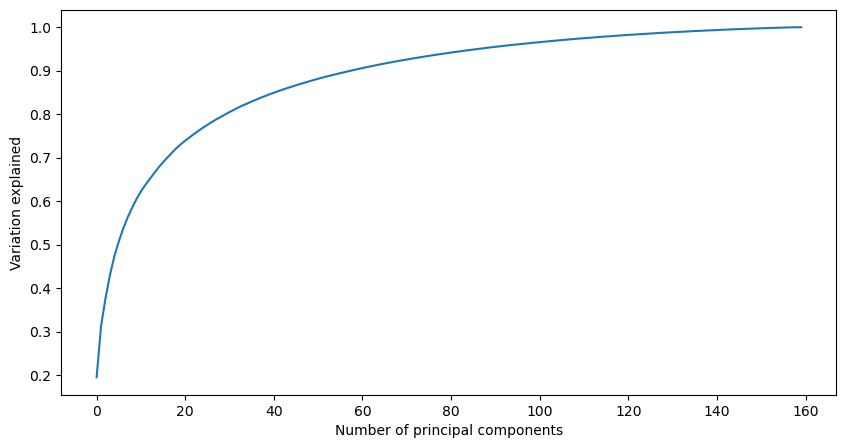

In [217]:
plt.figure(figsize=(10, 5))

plt.plot(np.arange(0, pca_pet.n_components_), pca_pet.explained_variance_ratio_.cumsum())


plt.xlabel('Number of principal components')
plt.ylabel('Variation explained')

plt.show()

In [218]:
pca_pet.components_.shape

(160, 160)

In [219]:
pets_transformed_calc = np.dot(pets_norm, pca_pet.components_.T)
pets_transformed_calc[:4,:4]

array([[ 2.13298877,  1.82968433,  0.00378457,  0.23454801],
       [ 2.2230759 ,  1.65608741, -0.02982544,  0.32022199],
       [ 2.19646341,  1.66149762, -0.06743538,  0.40271459],
       [ 2.19958107,  1.67324063,  0.01585092,  0.40132913]])

In [220]:
pets_transformed[:4,:4]

array([[ 2.29295821,  2.33271157, -0.17122085,  0.28003532],
       [ 2.38304534,  2.15911466, -0.20483086,  0.3657093 ],
       [ 2.35643285,  2.16452486, -0.2424408 ,  0.4482019 ],
       [ 2.35955051,  2.17626788, -0.15915449,  0.44681644]])

In [221]:
np.allclose(pets_transformed_calc, pets_transformed)

False

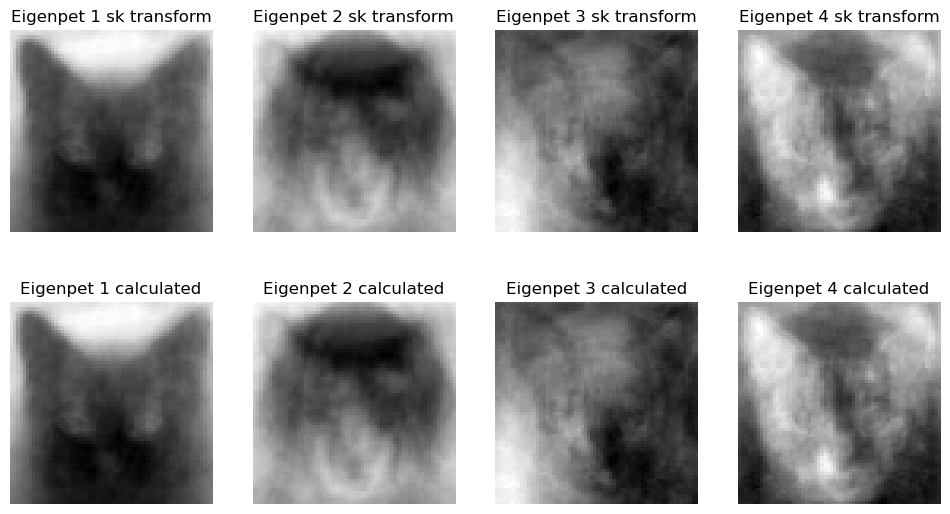

In [222]:
fig = plt.figure(figsize=(12, 10))
for i in range(4):
    ax = plt.subplot(3, 4, i + 1)
    plot_image_from_vector(pets_transformed[:,i], ax = ax, show = False)
    ax.set_title(f"Eigenpet {i+1} sk transform")
for i in range(4):
    ax = plt.subplot(3, 4, i + 5)
    plot_image_from_vector(pets_transformed_calc[:,i], ax = ax, show = False)
    ax.set_title(f"Eigenpet {i+1} calculated")

plt.show()

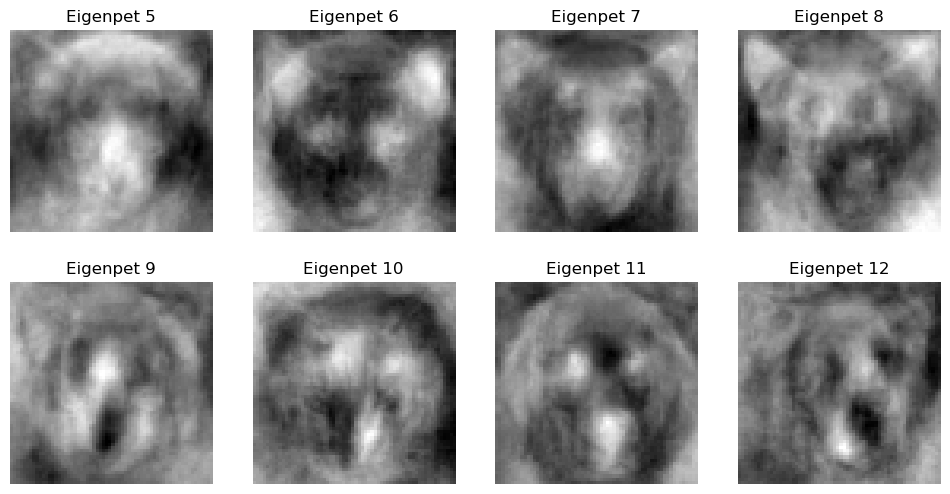

In [223]:
fig = plt.figure(figsize=(12, 6))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plot_image_from_vector(pets_transformed[:,i+4], ax = ax, show = False)
    ax.set_title(f"Eigenpet {i+5}")
plt.show()

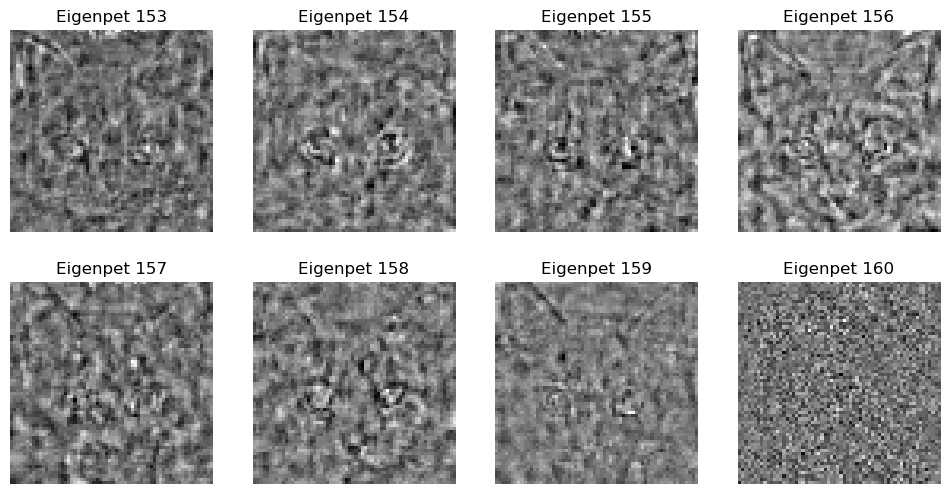

In [224]:
fig = plt.figure(figsize=(12, 6))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plot_image_from_vector(pets_transformed[:,i+152], ax = ax, show = False)
    ax.set_title(f"Eigenpet {i+153}")
plt.show()


In [225]:
pets_transformed.shape

(4096, 160)

In [226]:
res = np.dot(pets_transformed[:,1:50], pca_pet.components_.T[:,1:50].T)
res.shape

(4096, 160)

In [227]:
def plot_reverse_transform(image_idx, n_components_list=[2, 20, 60, 160]):
    n = len(n_components_list)
    fig = plt.figure(figsize=(12, 3))
    for i in range(n):
        res = np.dot(pets_transformed[:,1:n_components_list[i]], pca_pet.components_[1:n_components_list[i]])
        ax = plt.subplot(1, n, i + 1)
        plot_image_from_vector(res[:, image_idx], ax = ax, show = False)
        ax.set_title(f"{n_components_list[i]} principal components")

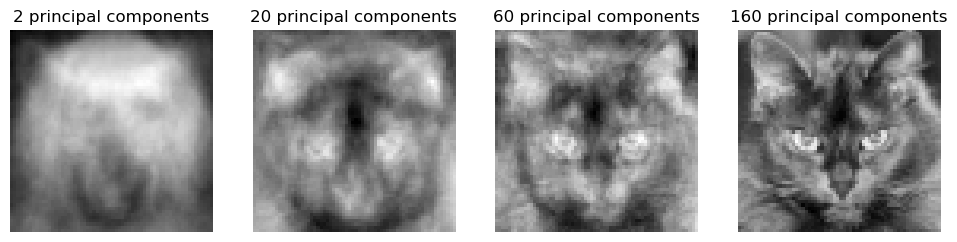

In [228]:
plot_reverse_transform(51)

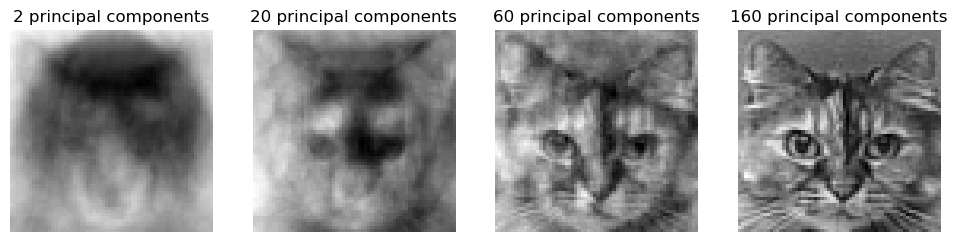

In [229]:
plot_reverse_transform(79)

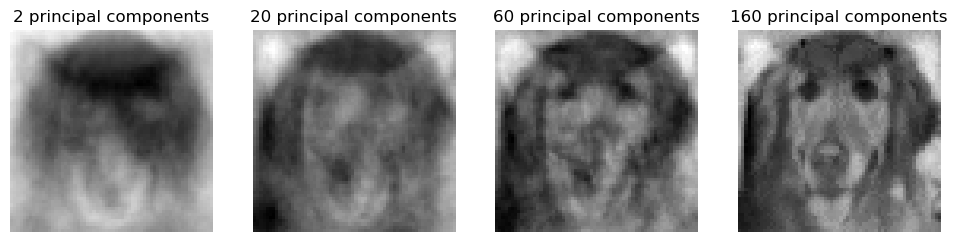

In [230]:
plot_reverse_transform(80)

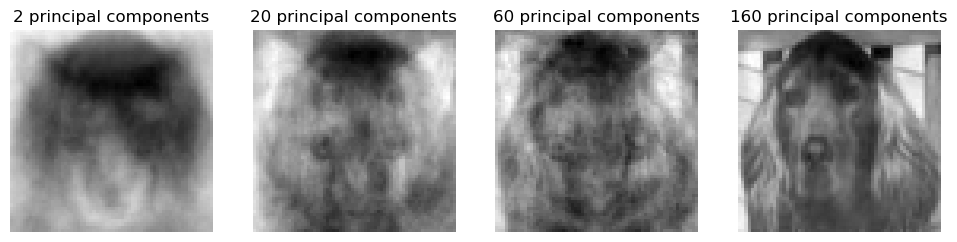

In [231]:
plot_reverse_transform(130)

We decide to keep 60 principal components, wich is explained variance ratio of 0.9.

In [232]:
np.sum(pca_pet.explained_variance_ratio_[:60])

0.9038487537701266

In [233]:
pets_transformed_60 = pets_transformed[:, :60] # == 60 eigenpets in columns
pets_transformed_60.shape

(4096, 60)

In [234]:
weights_60 = pca_pet.explained_variance_[:60].reshape(60,1) # 60 eigenvalues in (60,1) instead of (60,) shape
weights_60.shape

(60, 1)

In [235]:
pets_norm_array = np.array(pets_norm)
pets_norm.shape

(4096, 160)

In [236]:
cat_mean_vec = (np.array(cat_mean)).reshape(4096, 1)
dog_mean_vec = (np.array(dog_mean)).reshape(4096, 1)
pet_mean_vec = (np.array(pet_mean)).reshape(4096, 1)

We calculate distance from eigenpets of the mean cat and dog, first image from the dataset, image of cat that is not in the dataset and an image of banana to demonstrate how "differentness" is captured with only 60 principal components.

In [237]:
cat_mean_vec_transformed = np.dot((cat_mean_vec - pet_mean_vec).T, pets_transformed_60) 
dog_mean_vec_transformed = np.dot((dog_mean_vec - pet_mean_vec).T, pets_transformed_60)

In [238]:
pet_norm_0 = pets_norm_array[:,0].reshape(4096,1)  # first cat from dataset
pet_norm_0.shape

(4096, 1)

In [239]:
pet_0_transformed = np.dot(pet_norm_0.T, pets_transformed_60)
pet_0_transformed.shape

(1, 60)

In [240]:
def preprocess_image(image_raw):
    image_r, image_g, image_b = [image_raw[:, :, i] for i in range(3)] # split chanels
    image_grey = image_r / 3 + image_g / 3 + image_b / 3 # greyscale without correction
    image_norm = image_grey / 255 # normalize
    image_resized = resize(image_norm, (64, 64)) # sklearn resize
    image_vector = image_resized.ravel(order="F")
    

    return {
        "raw": image_raw,
        "gray": image_grey,
        "resized": image_resized,
        "vector": image_vector
    }
    

def plot_preprocess(preprocess_dict):
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 5))

    plot_image(preprocess_dict["raw"], ax = ax1, show = False)
    ax1.set_title("Raw image")
    
    plot_image(preprocess_dict["gray"], ax = ax2, cmap = "gray", show = False)
    ax2.set_title("Grayscale")
    
    plot_image(preprocess_dict["resized"], ax = ax3, cmap = "gray", show = False)
    ax3.set_title("Resized image")
    
    plt.show()
    

In [241]:
cat_url = "https://cdn.shopify.com/s/files/1/0331/9182/1447/articles/10_fascinating_facts_about_black_cats-3.jpg?v=1667409596&width=750"

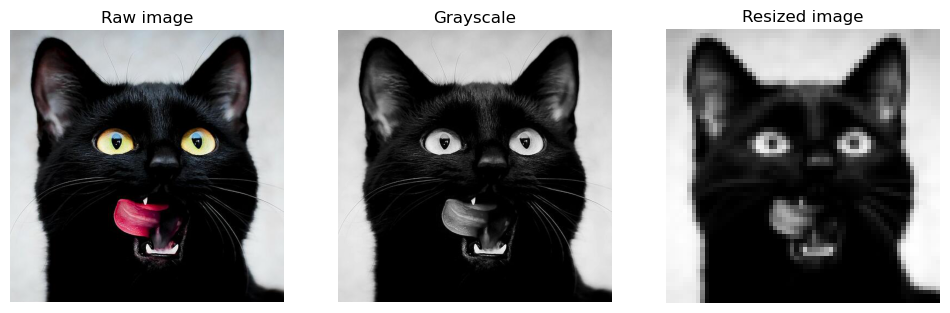

In [242]:
cat_image = read_image(cat_url)
cat_cropped = cat_image[:,125:625] # crop
cat_preprocess = preprocess_image(cat_cropped)
plot_preprocess(cat_preprocess)

In [243]:
cat_vector = cat_preprocess["vector"].reshape(4096, 1)
cat_vector.shape

(4096, 1)

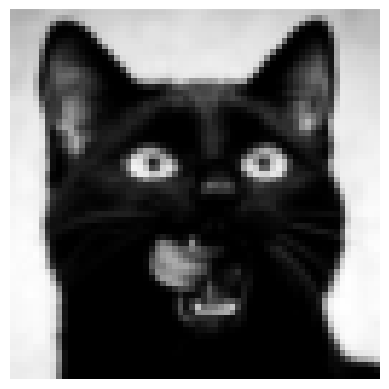

In [244]:
plot_image_from_vector(cat_vector) # make sure the vector is in the same direction

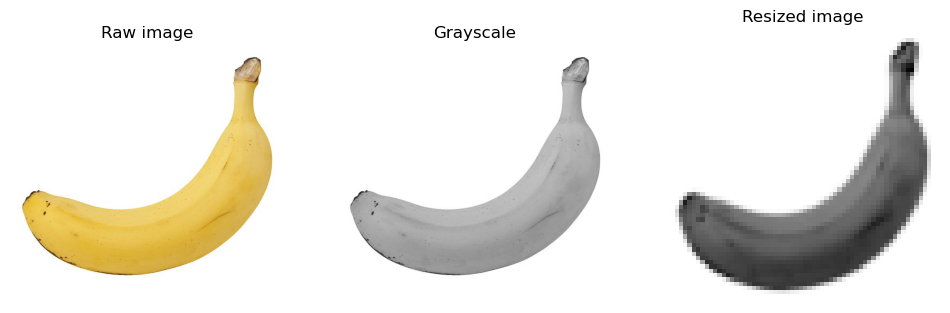

In [245]:
banana_image = read_image("https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Banana-Single.jpg/680px-Banana-Single.jpg?20150318233437")
banana_preprocess = preprocess_image(banana_image)
plot_preprocess(banana_preprocess)

In [246]:
banana_vector = banana_preprocess["vector"].reshape(4096, 1)
banana_vector.shape

(4096, 1)

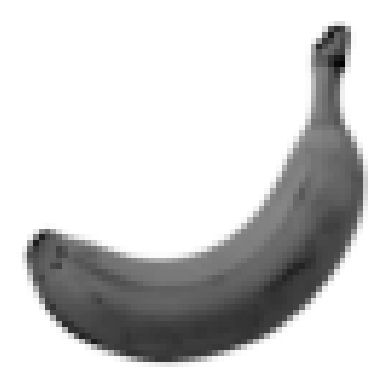

In [247]:
plot_image_from_vector(banana_vector) 

In [248]:
new_cat_norm = cat_vector - pet_mean_vec
new_cat_norm.shape

(4096, 1)

In [249]:
new_cat_transformed = np.dot(new_cat_norm.T, pets_transformed_60)
new_cat_transformed.shape

(1, 60)

In [250]:
banana_norm = banana_vector - pet_mean_vec
banana_norm.shape

(4096, 1)

In [251]:
banana_transformed = np.dot(banana_norm.T, pets_transformed_60)
banana_transformed.shape

(1, 60)

MSE between the transformed images would be better but for simplicity we plot them as function of the number of Eigenpet.

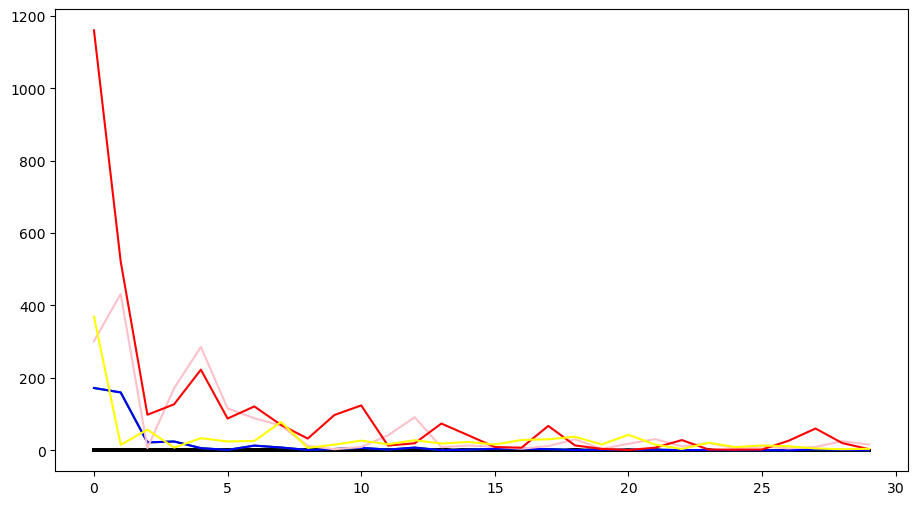

In [252]:
n = 30 # number of points to show, n<=60
x = np.arange(n)

plt.figure(figsize=(11,6))

plt.plot(x, np.abs(pets_transformed_60.T)[:n], color = "black", label = "eigenpets")
plt.plot(x, np.abs(cat_mean_vec_transformed.T)[:n], color = "green", label = "mean cat")
plt.plot(x, np.abs(dog_mean_vec_transformed.T)[:n], color = "blue", label = "mean dog")
plt.plot(x, np.abs(pet_0_transformed.T)[:n], color = "pink", label = "cat from the dataset")
plt.plot(x, np.abs(new_cat_transformed.T)[:n], color = "red", label = "new cat")
plt.plot(x, np.abs(banana_transformed.T)[:n], color = "yellow", label = "banana")
    
#plt.legend(bbox_to_anchor=(1, 1))

plt.show()

Well, the fact that the banana is closer to the eigenpet than the black cat, clearly indikates that we've done something very wrong, however we will investigate what some other time...

### References

- numpy

Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). DOI: 10.1038/s41586-020-2649-2. [Publisher link](https://www.nature.com/articles/s41586-020-2649-2)

- sklearn

[Scikit-learn: Machine Learning in Python](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html), Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

- Wikipedia


[Eigenvalues and eigenvectors](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors)

[Eigendecomposition of a matrix](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix)

[Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)

[Eigenface](https://en.wikipedia.org/wiki/Eigenface)

[Singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition)


- other

[Bioramble PCA - Parts 1 to 5](https://bioramble.wordpress.com/2015/08/12/pca-part-1-what-is-pca-and-what-can-it-do-for-us/)

[Understanding Principle Component Analysis(PCA) step by step.](https://medium.com/analytics-vidhya/understanding-principle-component-analysis-pca-step-by-step-e7a4bb4031d9)

[Principal Component Analysis (PCA) in Machine Learning— You will never find it tough again](https://medium.com/codex/principal-component-analysis-pca-how-it-works-mathematically-d5de4c7138e6)

[A quick guide to color image compression using PCA in python](https://towardsdatascience.com/dimensionality-reduction-of-a-color-photo-splitting-into-rgb-channels-using-pca-algorithm-in-python-ba01580a1118)

